# Importation des packages

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from DTW import *
from HMM import *
from Recons import *
import time
from tabata.opset import Opset
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
 

In [15]:
input_file = "../tabata/notebooks/data/in/AFL1EB.h5"
ds= Opset(input_file)
ds.plot()

In [16]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

def clean_data(input_file, output_file):
    # Chargement des données
    ds = Opset(input_file)
    print(f"Taille du df avant nettoyage : {len(ds)}")

    clean_ds = Opset(output_file)  # On va directement nettoyer et sauvegarder ici
    clean_ds.clean()

    for idx, df in enumerate(ds.iterator()):
        if max(df["F[N]"]) > 0:
            x = df.index
            t = (x - x[0]).total_seconds()

            # Vérification de la régularité de l'horodatage
            dt = np.diff(x) / np.timedelta64(1, 's')  # Conversion en secondes
            dt_clean = dt[~np.isnan(dt)]  # Suppression des NaN

            if len(dt_clean) > 0 and any(dt_clean != dt_clean[0]):
                name = df.index.name
                median_dt = np.median(dt_clean)
                df.index = pd.date_range(start=x[0], periods=len(df), freq=pd.Timedelta(seconds=median_dt))
                df.index.name = name  

            # Détection et suppression des faux atterrissages
            if "ALT[m]" in df.columns:
                altitude = df["ALT[m]"]
                minima_indices, _ = find_peaks(-altitude, prominence=100)
                
                has_fake_landing = any(
                    idx_min != 0 and idx_min != len(altitude) - 1 and 
                    altitude.iloc[idx_min] < 500 and 
                    (altitude.iloc[idx_min:] > altitude.iloc[idx_min] + 1000).any()
                    for idx_min in minima_indices
                )

                if has_fake_landing:
                    print(f"Vol exclu (faux atterrissage détecté) : Vol #{idx}")
                    continue

            clean_ds.put(df)

    print(f"Taille du df après nettoyage : {len(clean_ds)}")
    print(f"Fichier nettoyé sauvegardé sous {output_file}")

# Exemple d'appel
input_file = "../tabata/notebooks/data/in/AFL1EB.h5"
output_file = "../Data/cleaned/AFL1EB_c.h5"
clean_data(input_file, output_file)


Taille du df avant nettoyage : 52
Vol exclu (faux atterrissage détecté) : Vol #10
Taille du df après nettoyage : 47
Fichier nettoyé sauvegardé sous ../Data/cleaned/AFL1EB_c.h5


In [40]:
ds.records

['/record_00',
 '/record_01',
 '/record_02',
 '/record_03',
 '/record_04',
 '/record_05',
 '/record_11',
 '/record_12',
 '/record_13',
 '/record_14',
 '/record_15',
 '/record_16',
 '/record_17',
 '/record_18',
 '/record_19',
 '/record_20',
 '/record_21',
 '/record_22',
 '/record_23',
 '/record_24',
 '/record_25',
 '/record_26',
 '/record_27',
 '/record_28',
 '/record_29',
 '/record_30',
 '/record_31',
 '/record_32',
 '/record_33',
 '/record_34',
 '/record_35',
 '/record_36',
 '/record_37',
 '/record_38',
 '/record_39',
 '/record_40',
 '/record_41',
 '/record_42',
 '/record_43',
 '/record_44',
 '/record_45',
 '/record_46',
 '/record_47',
 '/record_48',
 '/record_49',
 '/record_50',
 '/record_51']

# Initialisation des données

OPSET '../Data/normalized/AFL1EB_normalized.h5' de 47 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None


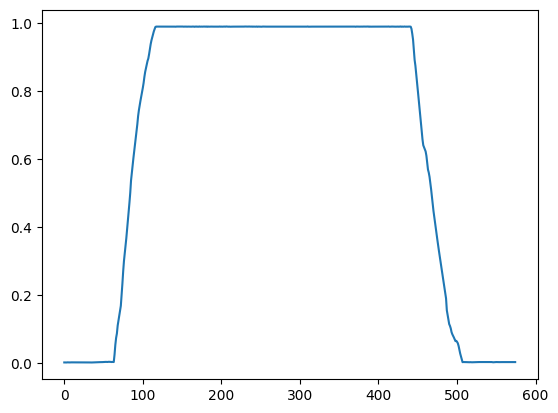

In [29]:
input_file = "../Data/normalized/AFL1EB_normalized.h5"
ds = Opset(input_file)
print(ds)
reference = ds[11]
target = ds[44]
reference, ref_obs = preprocess_data(reference)
target, tgt_obs = preprocess_data(target)
plt.plot(target["ALT[m]"].values)

# Ruptures

In [26]:
np.array(change_points)

array([ 35, 125, 176])

0


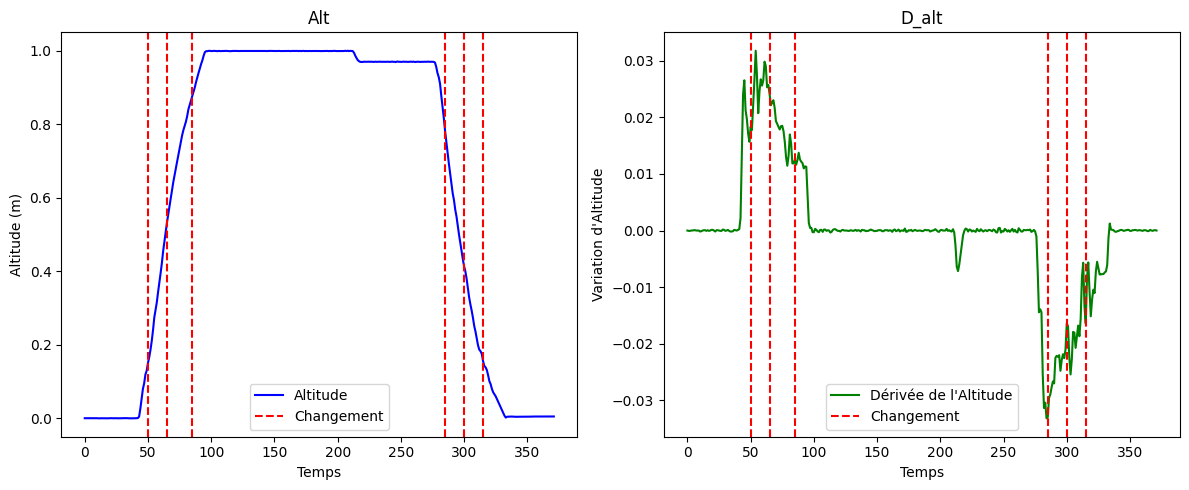

1


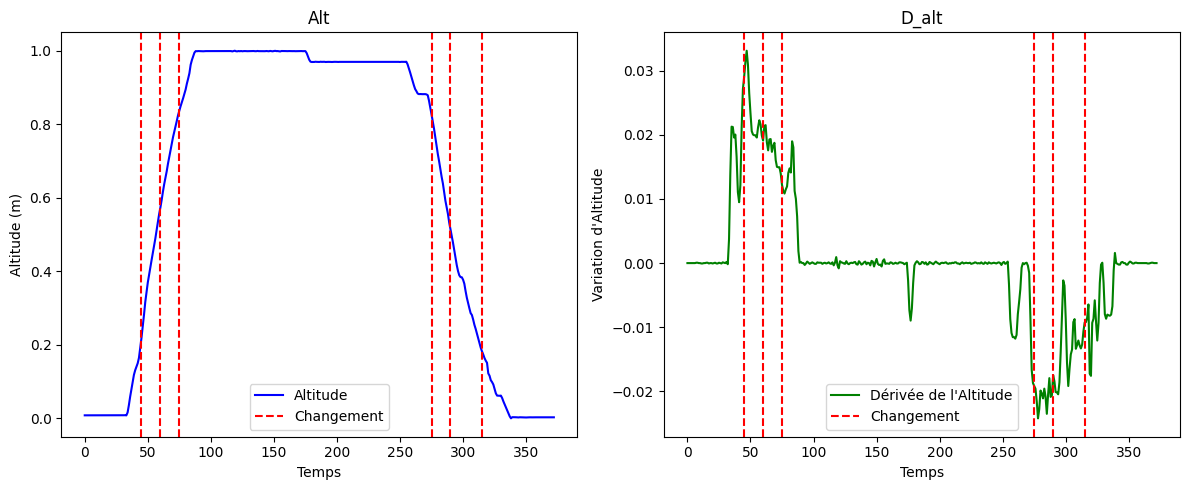

2


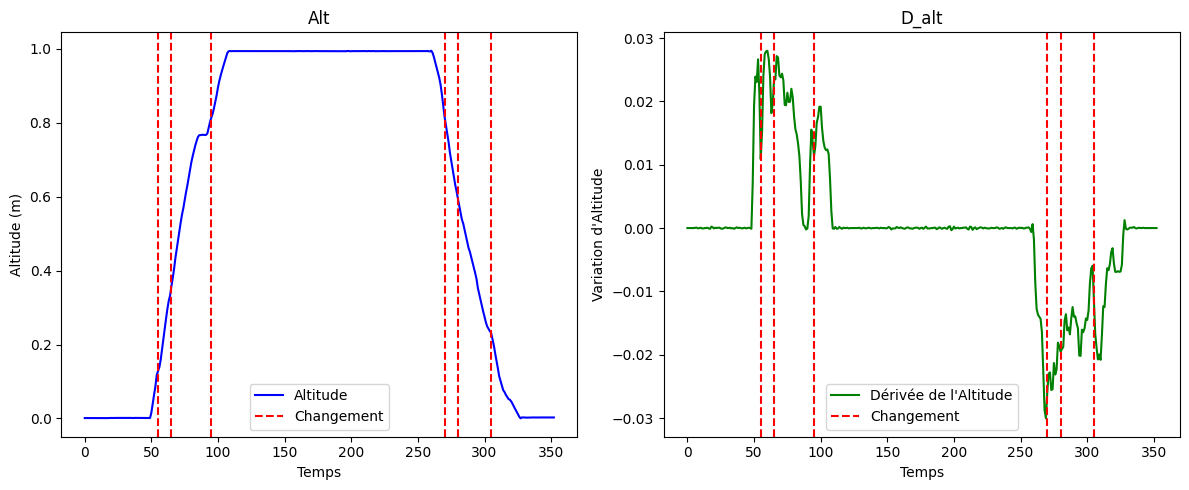

3


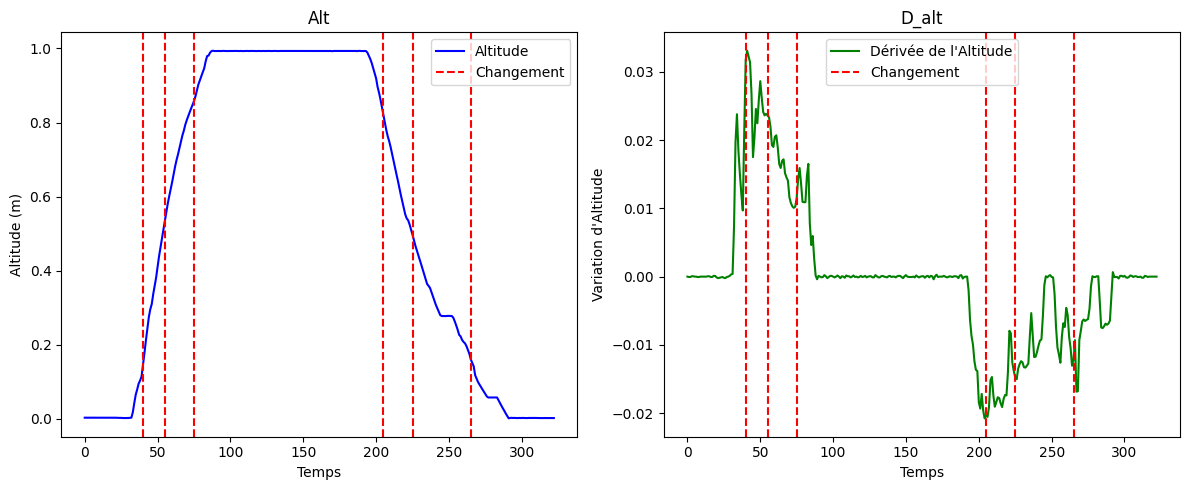

4


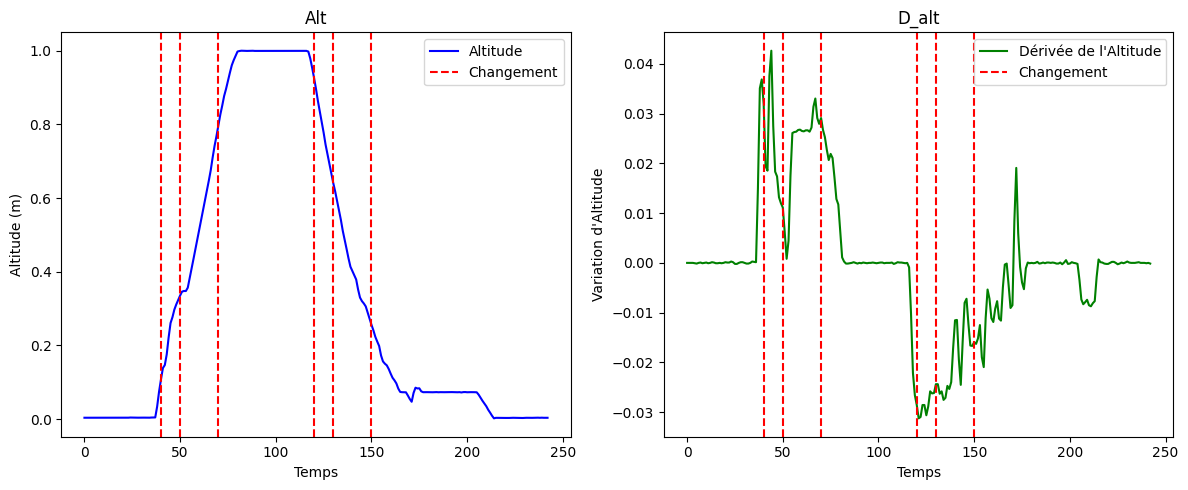

5


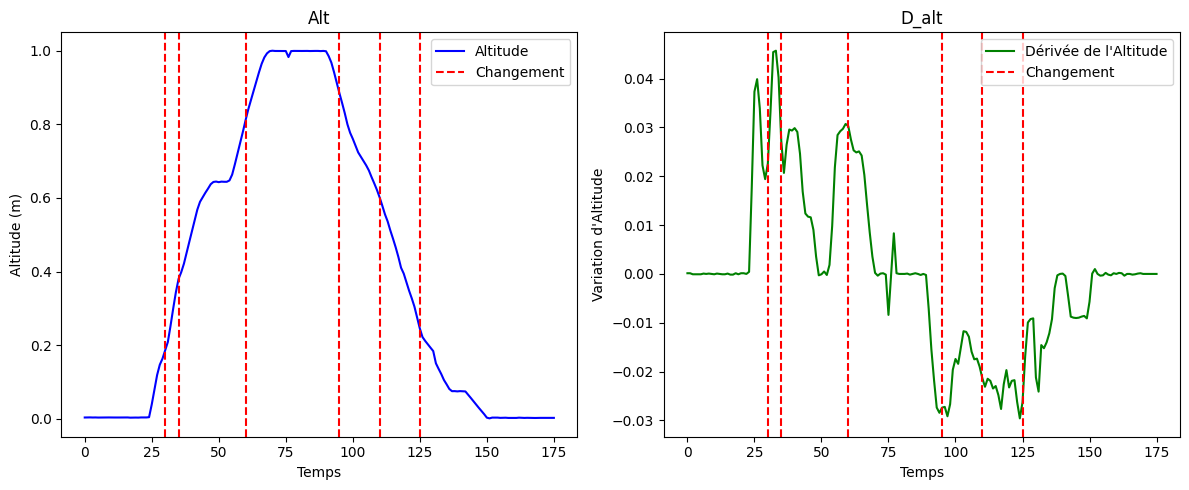

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt  
from scipy.ndimage import gaussian_filter1d  

for i in range(len(ds)):
    print(i)
    target = ds[i]
    target, tgt_obs = preprocess_data(target)
    altitude = target["ALT[m]"].values  
    time = np.arange(len(altitude))  

    d_altitude = np.gradient(altitude)

    window_size = 5
    #altitude_smooth = np.convolve(altitude, np.ones(window_size)/window_size, mode='same')
    #d_altitude_smooth = np.convolve(d_altitude, np.ones(window_size)/window_size, mode='same')

    alt = gaussian_filter1d(altitude, sigma=1)
    dalt = gaussian_filter1d(d_altitude, sigma=1)

    algo = rpt.Binseg(model="rbf").fit(np.column_stack((altitude, d_altitude)))
    change_points = algo.predict(n_bkps=6)  

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  

    axs[0].plot(time, altitude, label="Altitude", color='blue')
    for cp in change_points[:-1]:  
        axs[0].axvline(x=time[cp], color='red', linestyle='--', label="Changement" if cp == change_points[0] else "")
    axs[0].set_xlabel("Temps")
    axs[0].set_ylabel("Altitude (m)")
    axs[0].set_title("Alt")
    axs[0].legend()

    axs[1].plot(time, d_altitude, label="Dérivée de l'Altitude", color='green')
    for cp in change_points[:-1]:  
        axs[1].axvline(x=time[cp], color='red', linestyle='--', label="Changement" if cp == change_points[0] else "")
    axs[1].set_xlabel("Temps")
    axs[1].set_ylabel("Variation d'Altitude")
    axs[1].set_title("D_alt")
    axs[1].legend()

    plt.tight_layout()  
    plt.show()
    if i==5 :
        break


# Avec HMM

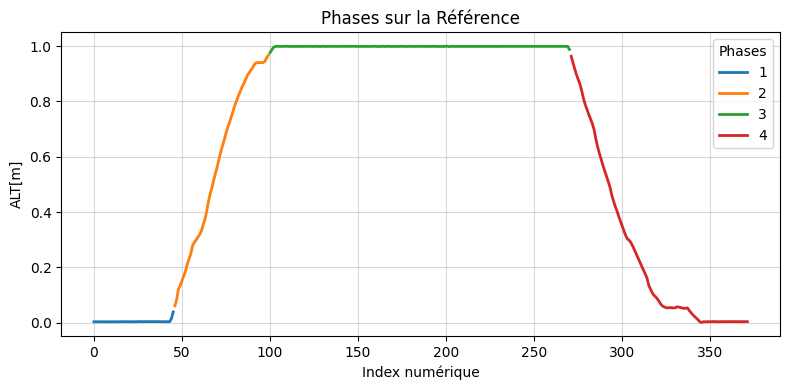

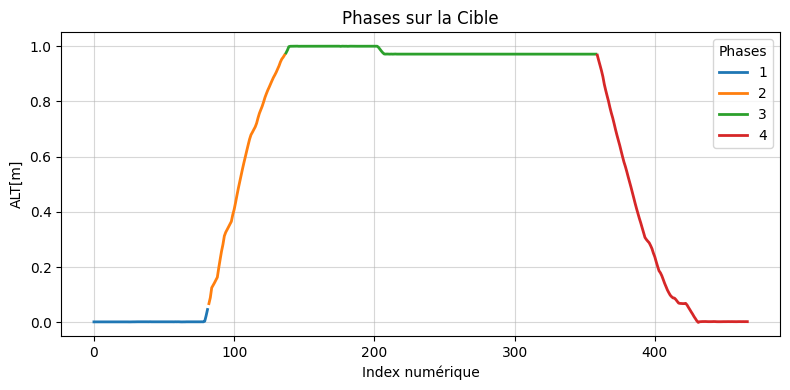

In [6]:
# Définir les phases
states = ["0", "1", "2", "3", "4"]
n_states = len(states)

model = create_hmm_model(n_states)
model.fit(ref_obs)
reference = detect_phases(reference, model, states)
target = detect_phases(target, model, states)
# Visualisation des phases détectées
plot_phases_on_flight(reference, phases_col="Phase", value_col="ALT[m]", title="Phases sur la Référence")
plot_phases_on_flight(target, phases_col="Phase", value_col="ALT[m]", title="Phases sur la Cible")



Alignement des phases : 

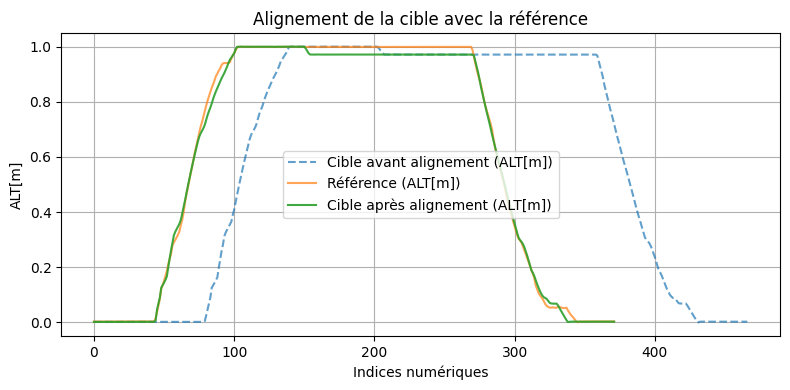

In [7]:
aligned_data = align_by_phase(reference, target, states)
plot_alignment(reference, target, aligned_data)


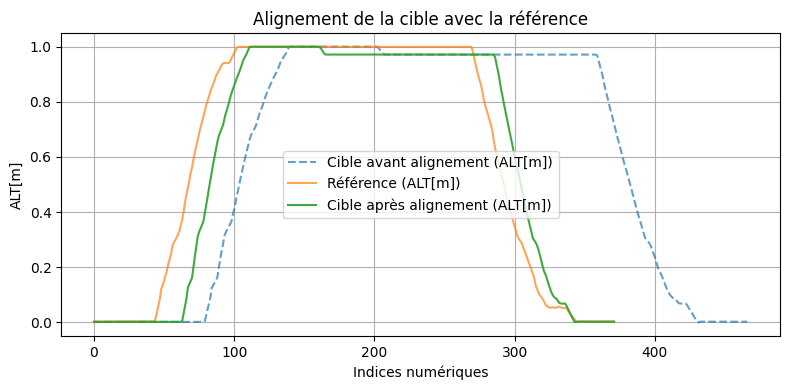

In [8]:
aligned_data_no_phase = align_without_phases(reference,target)
plot_alignment(reference, target, aligned_data_no_phase)

[46]
[46]


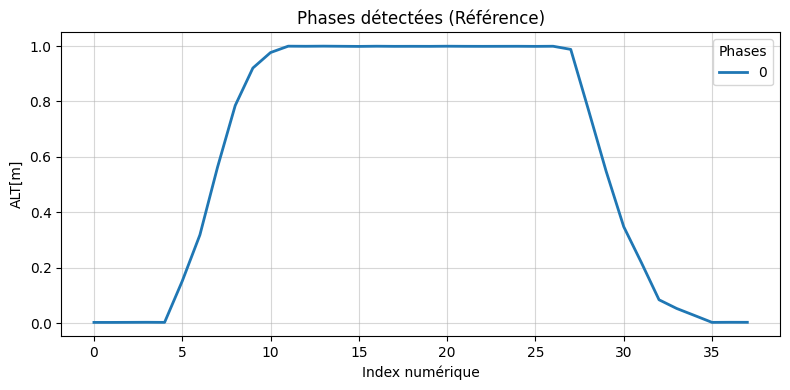

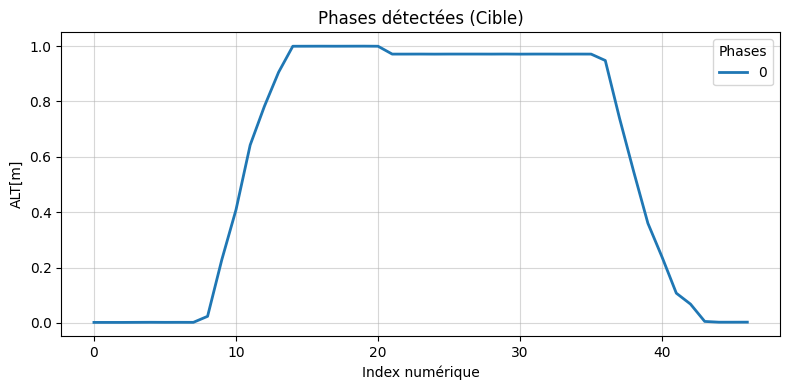

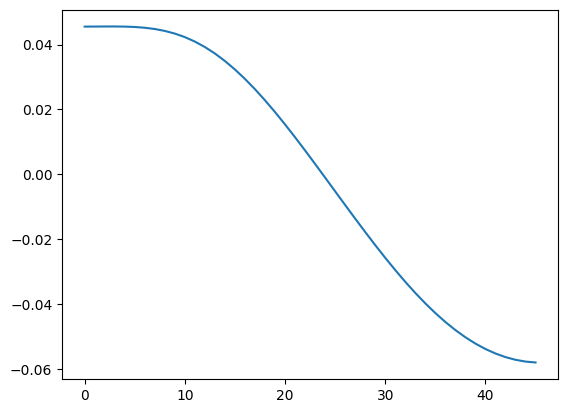

In [9]:
import numpy as np
import ruptures as rpt

def detect_phases_ruptures(data, pen=10, model="rbf"):

    alt = data["ALT[m]"].values
    #d_alt = np.gradient(alt)
    #d2_alt = np.gradient(d_alt)
    signal = gaussian_filter1d(np.diff(data_tgt["ALT[m]"].values),sigma=10)

    algo = rpt.Pelt(model=model).fit(signal)
    breakpoints = algo.predict(pen=pen)
    print(breakpoints)
    phases = np.zeros(len(data), dtype=int)
    start = 0
    for phase, bp in enumerate(breakpoints):
        phases[start:bp] = phase
        start = bp
    
    data = data.copy()
    data["Phase"] = phases
    return data


data_ref, _ = preprocess_data(reference,subset_fraction=0.1)
data_tgt, _ = preprocess_data(target,subset_fraction=0.1)

# Détection des phases avec ruptures
data_ref_phases = detect_phases_ruptures(data_ref, pen=100, model="rbf")
data_tgt_phases = detect_phases_ruptures(data_tgt, pen=100, model="rbf")
plot_phases_on_flight(data_ref_phases, phases_col="Phase", value_col="ALT[m]", title="Phases détectées (Référence)")
plot_phases_on_flight(data_tgt_phases, phases_col="Phase", value_col="ALT[m]", title="Phases détectées (Cible)")
plt.plot(gaussian_filter1d(np.diff(data_tgt["ALT[m]"].values),sigma=10))
df = pd.DataFrame(gaussian_filter1d(np.diff(data_tgt["ALT[m]"].values),sigma=10))
df.to_csv("dalt.csv")

# Avec DTW

In [10]:
reference

ALT[m]     Tisa[K]  TAS[m/s]   Vz[m/s]     Masse[kg]  \
record_16                                                                     
2013-02-06 10:26:00  0.003161  829.986117       0.0 -0.123079  15152.382811   
2013-02-06 10:26:20  0.003161  829.986117       0.0 -0.015011  15152.382811   
2013-02-06 10:26:40  0.003161  829.986117       0.0  0.055996  15152.382811   
2013-02-06 10:27:00  0.003278  829.963294       0.0  0.013201  15152.297505   
2013-02-06 10:27:20  0.003161  829.986117       0.0 -0.040038  15151.826163   
...                       ...         ...       ...       ...           ...   
2013-02-06 12:28:20  0.003512  829.917647       0.0 -0.048017  13786.580256   
2013-02-06 12:28:40  0.003512  829.917647       0.0 -0.021615  13786.580256   
2013-02-06 12:29:00  0.003512  829.917647       0.0 -0.015812  13786.580256   
2013-02-06 12:29:20  0.003512  829.917647       0.0  0.003480  13786.580256   
2013-02-06 12:29:40  0.003630  829.894823       0.0  0.045255  13786.580256   

                     F[N] Phase  
record_16                        
2013-02-06 10:26:00   0.0     1  
2013-02-06 10:26:20   0.0     1  
2013-02-06 10:26:40   0.0     1  
2013-02-06 10:27:00   0.0     1  
2013-02-06 10:27:20   0.0     1  
...                   ...   ...  
2013-02-06 12:28:20   0.0     4  
2013-02-06 12:28:40   0.0     4  
2013-02-06 12:29:00   0.0     4  
2013-02-06 12:29:20   0.0     4  
2013-02-06 12:29:40   0.0     4  

[372 rows x 7 columns]

Distance DTW : 1.6350017030147324


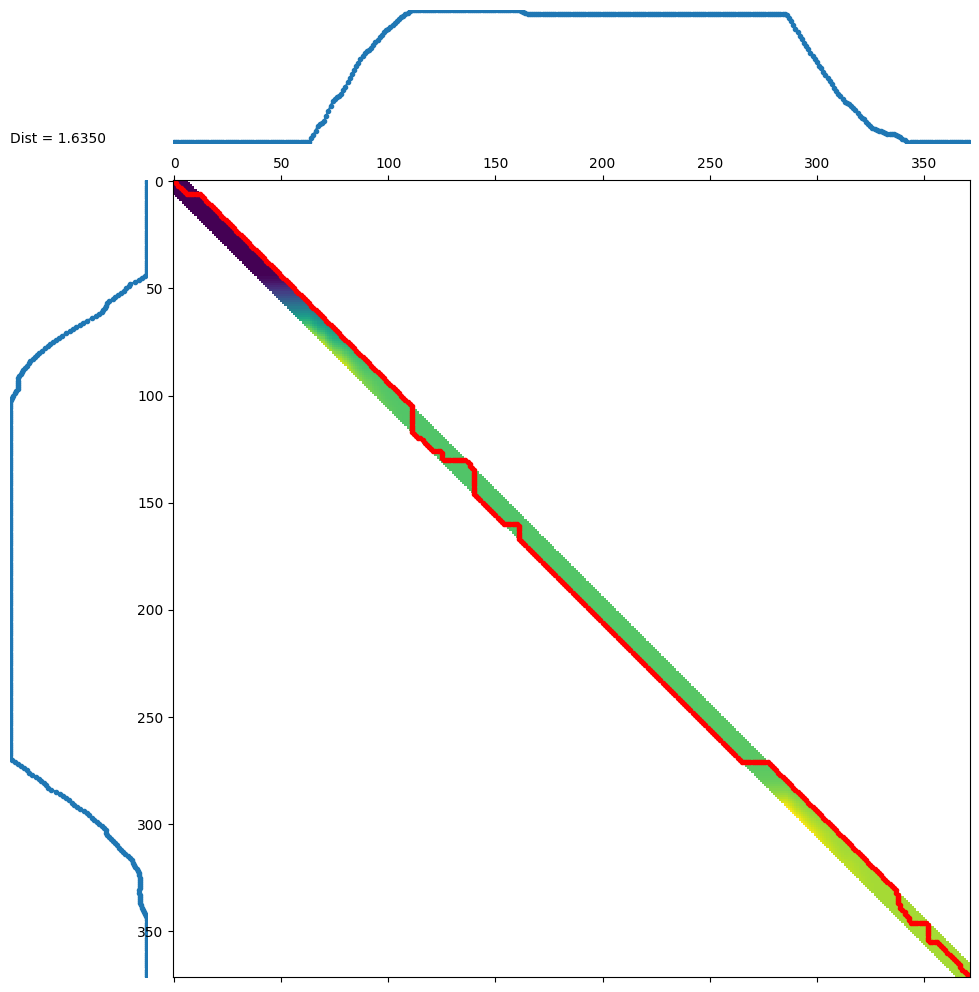

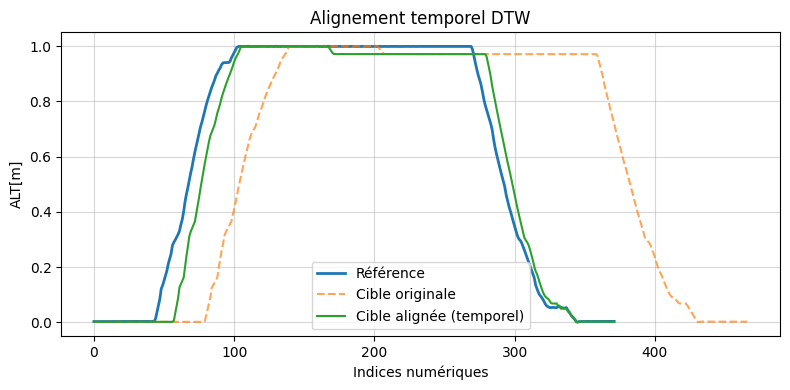

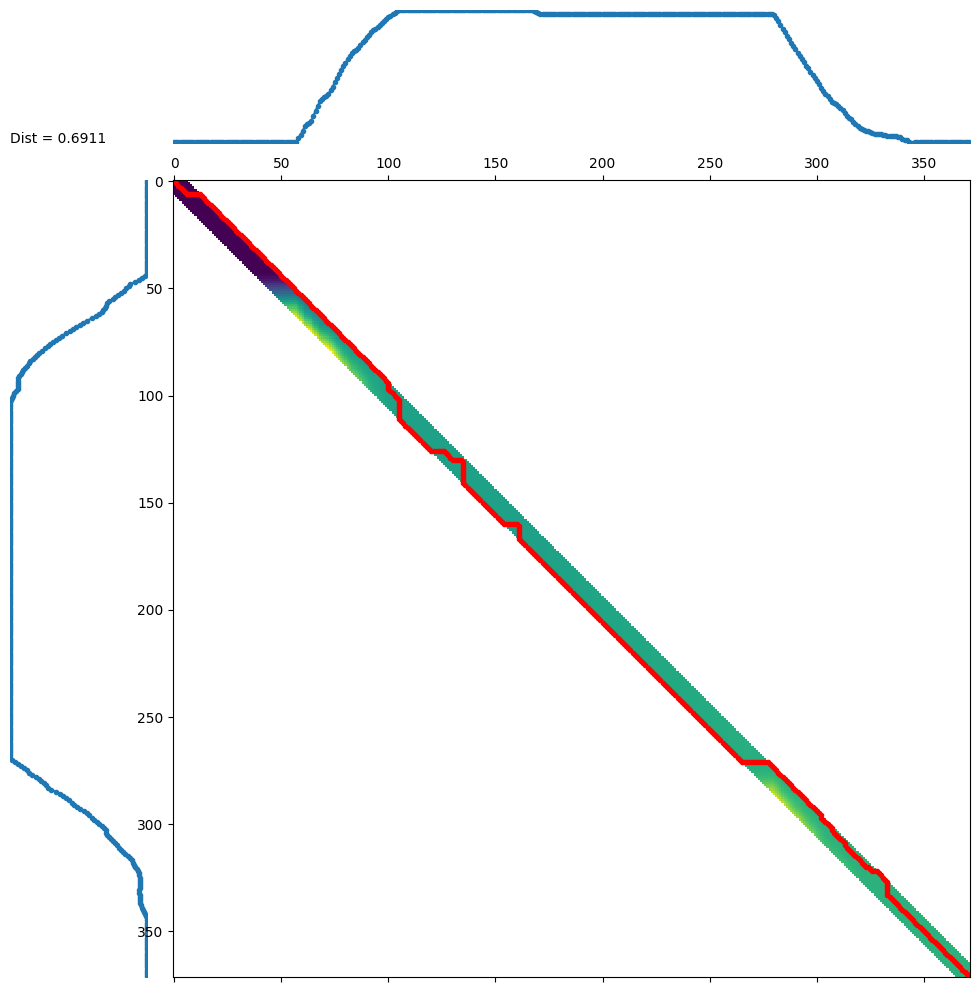

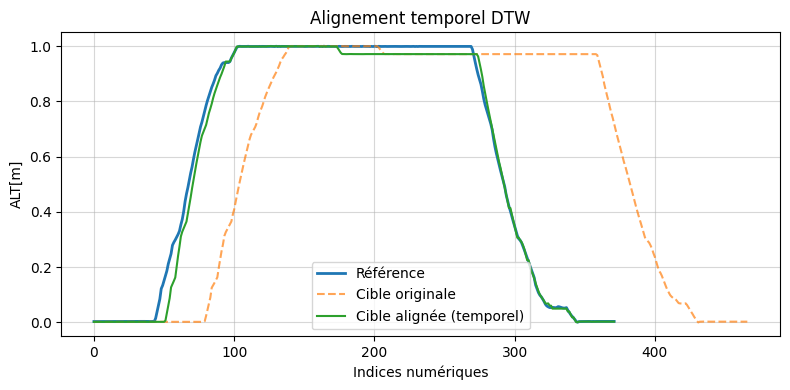

In [ ]:
distance, path = calculate_dtw(reference, aligned_data_no_phase, col = "ALT[m]",sens=1)
print(f"Distance DTW : {distance}")
aligned_target_DTW = align_with_dtw(reference, aligned_data_no_phase, path)
distance, path = calculate_dtw(reference, aligned_target_DTW, col = "ALT[m]",sens=1)
aligned_target_DTW = align_with_dtw(reference, aligned_target_DTW, path)


In [12]:
D = np.diff(path,axis=0)
P = np.prod(D,axis=1) != 0
N = np.array([True])
C = np.concatenate([N,P])
path2 = np.array(path)
path2 = path2[C,:]
len(path2)

335

In [13]:
reference

ALT[m]     Tisa[K]  TAS[m/s]   Vz[m/s]     Masse[kg]  \
record_16                                                                     
2013-02-06 10:26:00  0.003161  829.986117       0.0 -0.123079  15152.382811   
2013-02-06 10:26:20  0.003161  829.986117       0.0 -0.015011  15152.382811   
2013-02-06 10:26:40  0.003161  829.986117       0.0  0.055996  15152.382811   
2013-02-06 10:27:00  0.003278  829.963294       0.0  0.013201  15152.297505   
2013-02-06 10:27:20  0.003161  829.986117       0.0 -0.040038  15151.826163   
...                       ...         ...       ...       ...           ...   
2013-02-06 12:28:20  0.003512  829.917647       0.0 -0.048017  13786.580256   
2013-02-06 12:28:40  0.003512  829.917647       0.0 -0.021615  13786.580256   
2013-02-06 12:29:00  0.003512  829.917647       0.0 -0.015812  13786.580256   
2013-02-06 12:29:20  0.003512  829.917647       0.0  0.003480  13786.580256   
2013-02-06 12:29:40  0.003630  829.894823       0.0  0.045255  13786.580256   

                     F[N] Phase  
record_16                        
2013-02-06 10:26:00   0.0     1  
2013-02-06 10:26:20   0.0     1  
2013-02-06 10:26:40   0.0     1  
2013-02-06 10:27:00   0.0     1  
2013-02-06 10:27:20   0.0     1  
...                   ...   ...  
2013-02-06 12:28:20   0.0     4  
2013-02-06 12:28:40   0.0     4  
2013-02-06 12:29:00   0.0     4  
2013-02-06 12:29:20   0.0     4  
2013-02-06 12:29:40   0.0     4  

[372 rows x 7 columns]

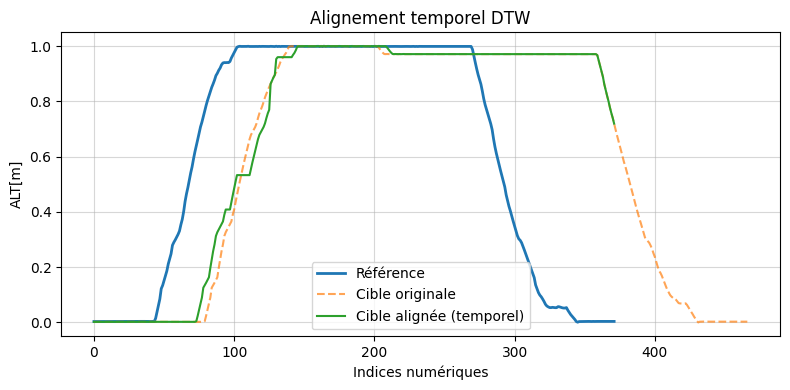

409

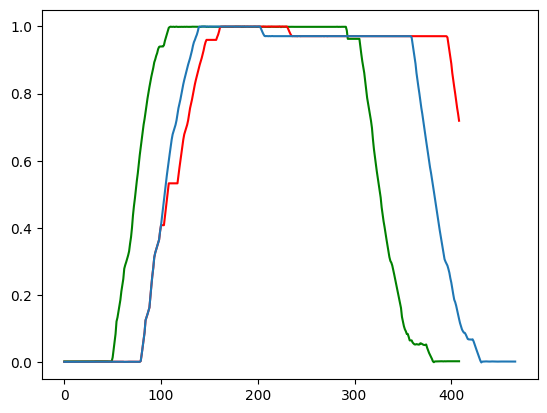

In [14]:
path1 = np.array(path)
aligned_target_DTW2 = align_with_dtw(reference, target, path)
plot_dtw_alignment(reference, target, aligned_target_DTW2, col="ALT[m]")
plt.plot(reference["ALT[m]"].values[path1[:,0]],'-g')
plt.plot(target["ALT[m]"].values[path1[:,1]],'-r')
plt.plot(target["ALT[m]"].values)
#plt.plot(aligned_target_DTW2["ALT[m]"].values)
len(path1)

Distance DTW : 0.233906606890344


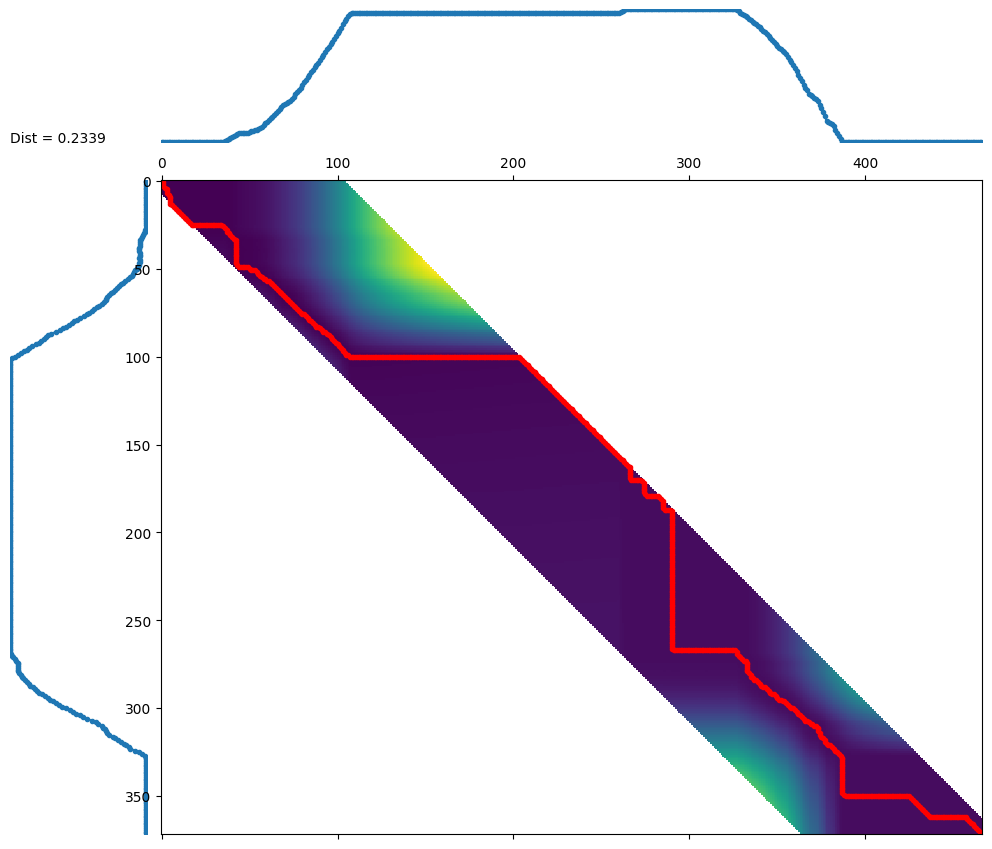

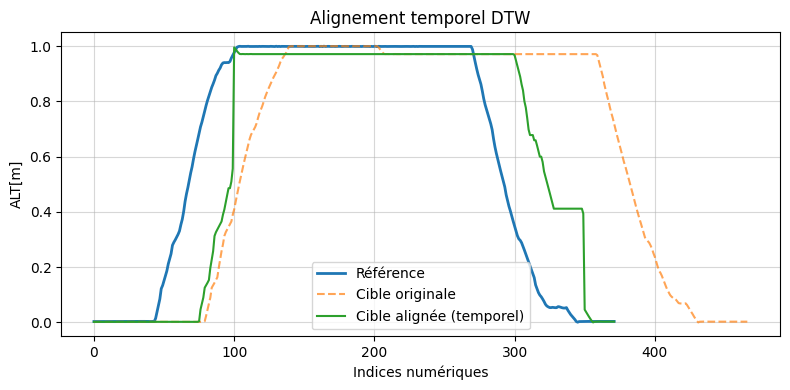

In [15]:
distance, path = calculate_dtw(reference, target, col = "ALT[m]",sens=-1)
print(f"Distance DTW : {distance}")
aligned_target_DTW = align_with_dtw(reference, target, path)
plot_dtw_alignment(reference, target, aligned_target_DTW, col="ALT[m]")


# Calcul d'erreurs

In [16]:
sync_error_no_phase = calculate_sync_error(reference, aligned_data_no_phase, value_col="ALT[m]", metric="RMSE")
print(f"Erreur de synchronisation sans phase (RMSE) : {sync_error_no_phase}")
sync_error_with_phase = calculate_sync_error(reference, aligned_data, value_col="ALT[m]", metric="RMSE")
print(f"Erreur de synchronisation HMM (RMSE) : {sync_error_with_phase}")
sync_error_DTW = calculate_sync_error(reference, aligned_target_DTW, value_col="ALT[m]", metric="RMSE")
print(f"Erreur de synchronisation DTW (RMSE) : {sync_error_DTW}")

print(f"Erreur avec origine sans phase (RMSE) : {calculate_sync_error(target, aligned_data_no_phase, value_col="ALT[m]", metric="RMSE")}")
print(f"Erreur avec origine HMM (RMSE) : {calculate_sync_error(target, aligned_data_no_phase, value_col="ALT[m]", metric="RMSE")}")
print(f"Erreur avec origine DTW (RMSE) : {calculate_sync_error(target, aligned_data_no_phase, value_col="ALT[m]", metric="RMSE")}")




Erreur de synchronisation sans phase (RMSE) : 0.13885939858563254
Erreur de synchronisation HMM (RMSE) : 0.02057599886173498
Erreur de synchronisation DTW (RMSE) : 0.27014877851642993


ValueError: Les longueurs des données de référence et de la cible alignée ne correspondent pas.

575
372


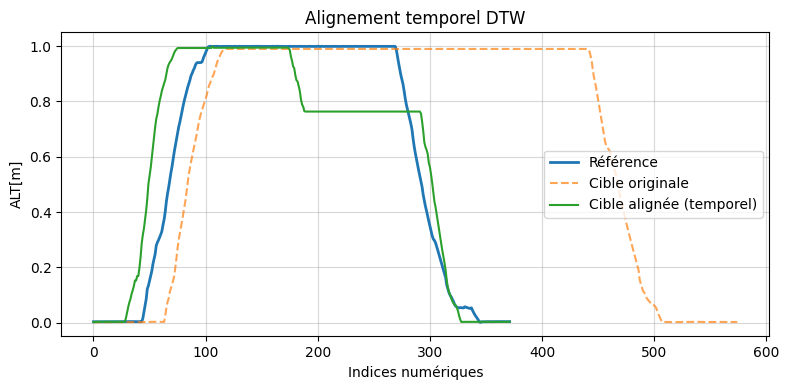

In [ ]:
aligned_target_barycenter = align_with_dtw_barycenter(reference, target, col="ALT[m]")
plot_dtw_alignment(reference, target, aligned_target_barycenter, col="ALT[m]")

# Boucle sur les targets : 

Vol 0
Vol 1
Vol 2
Vol 3
Vol 4
Vol 5
Vol 6
Vol 7
Vol 8
Vol 9
Vol 10
Vol 11
Vol 12
Vol 13
Vol 14
Vol 15
Vol 16
Vol 17
Vol 18
Vol 19
Vol 20


c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\dtaidistance\dtw_visualisation.py:234: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Vol 21
Vol 22
Vol 23
Vol 24
Vol 25
Vol 26
Vol 27
Vol 28
Vol 29
Vol 30
Vol 31
Vol 32
Vol 33
Vol 34
Vol 35
Vol 36
Vol 37
Vol 38
Vol 39
Vol 40
Vol 41
Vol 42
Vol 43
Vol 44
Vol 45
Vol 46


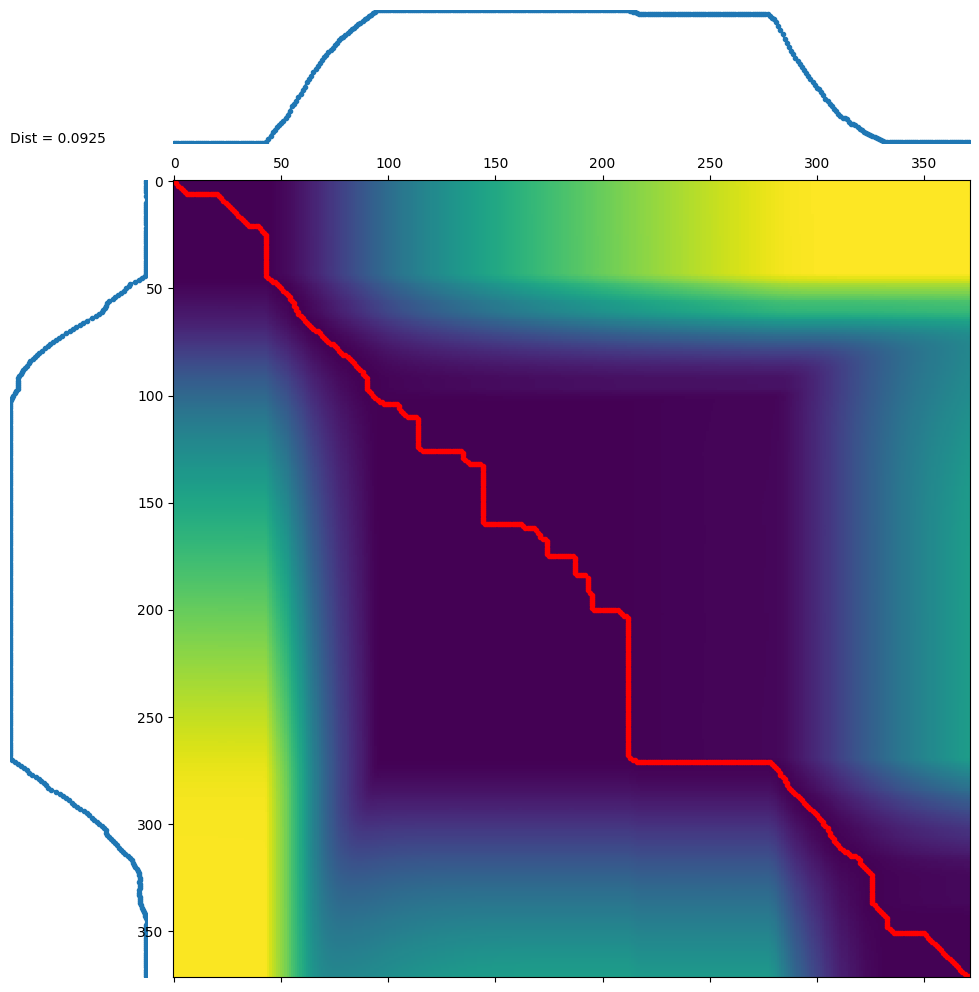

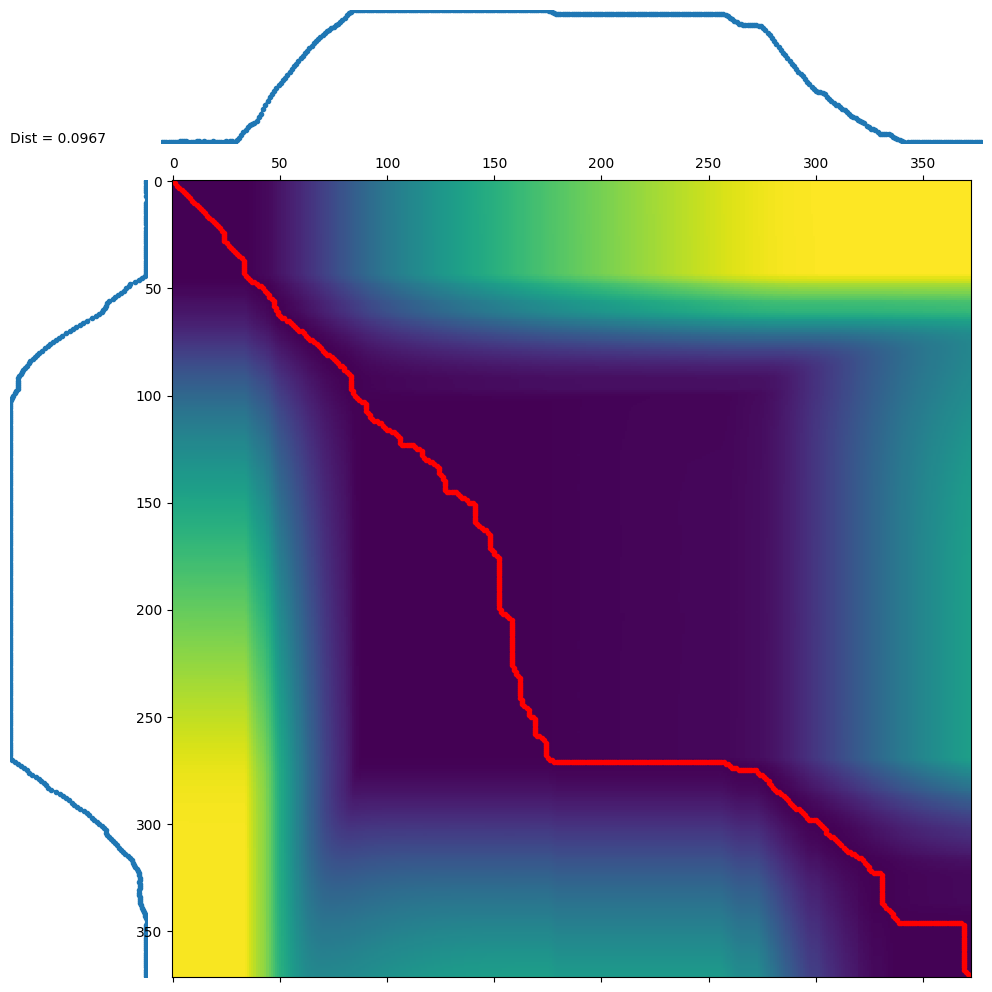

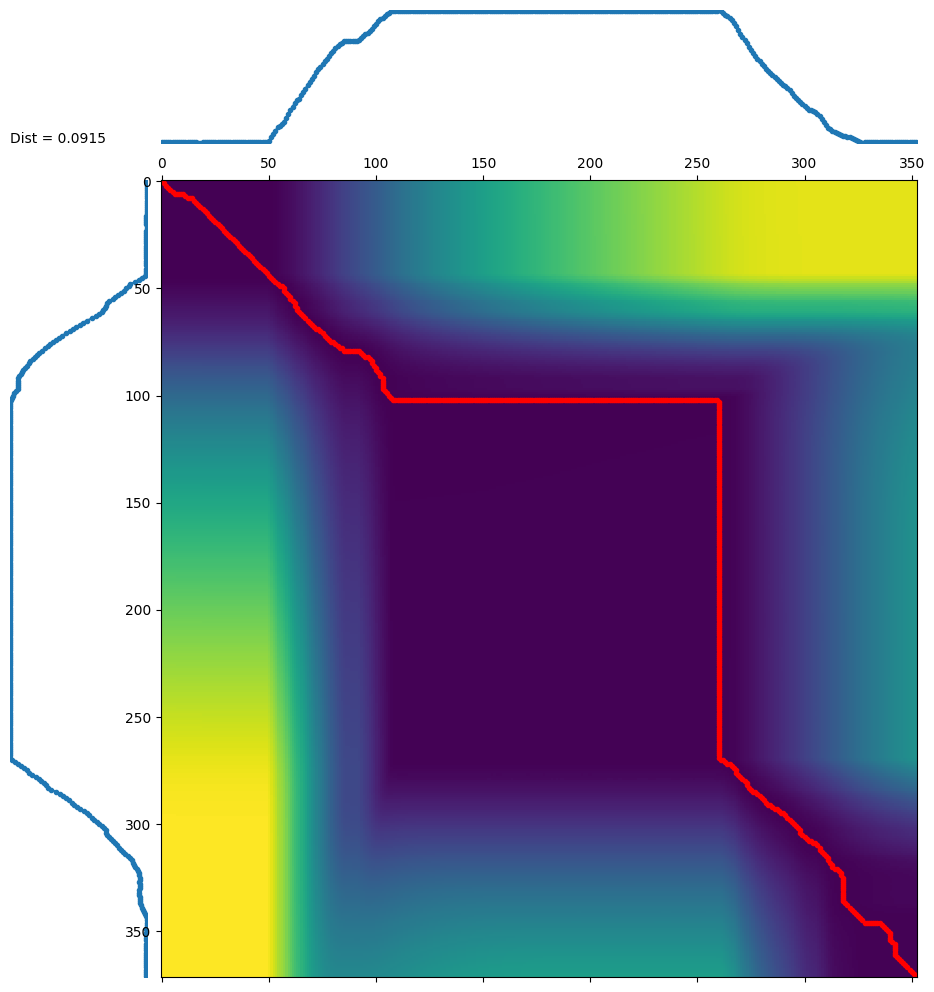

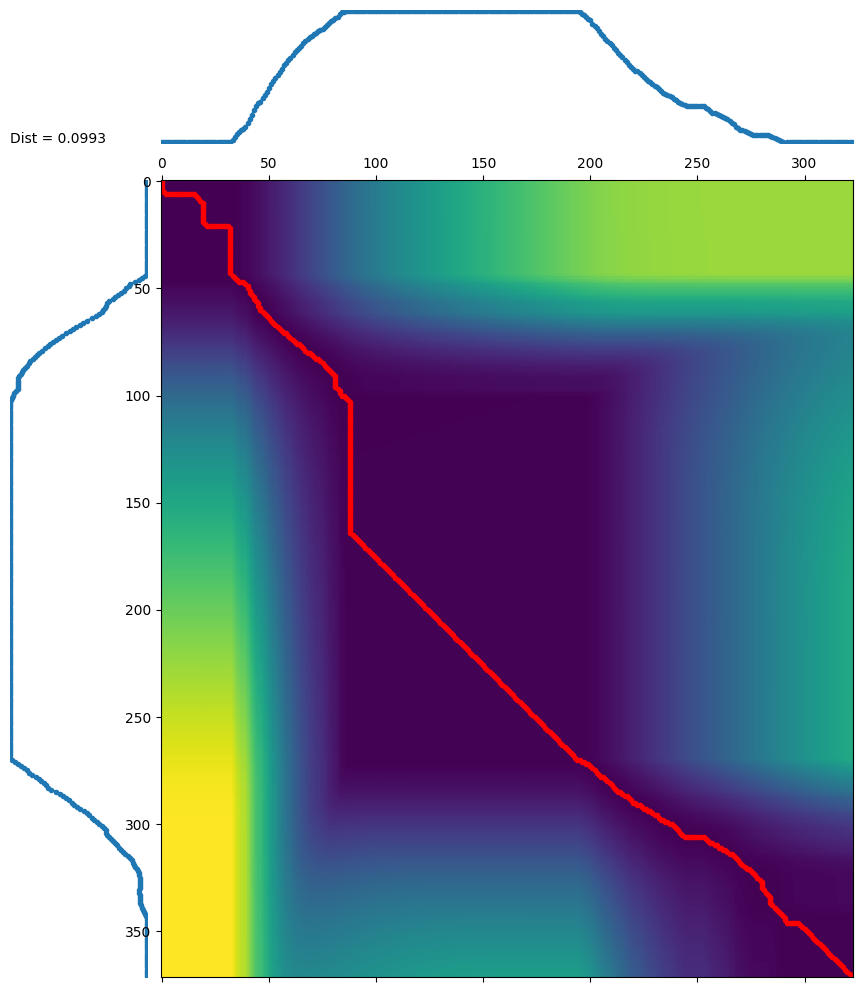

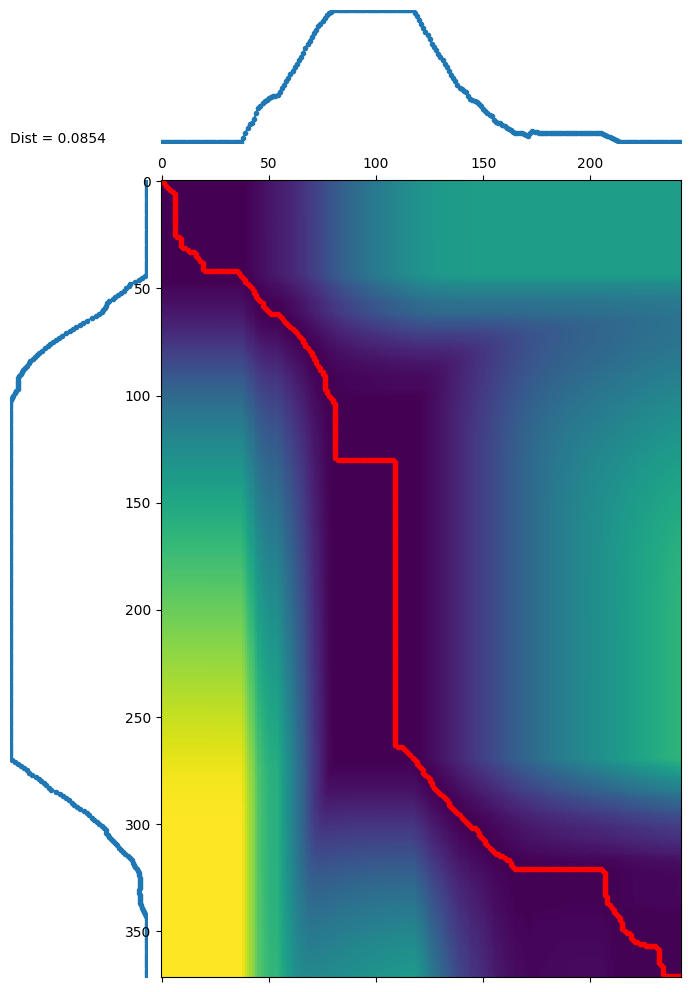

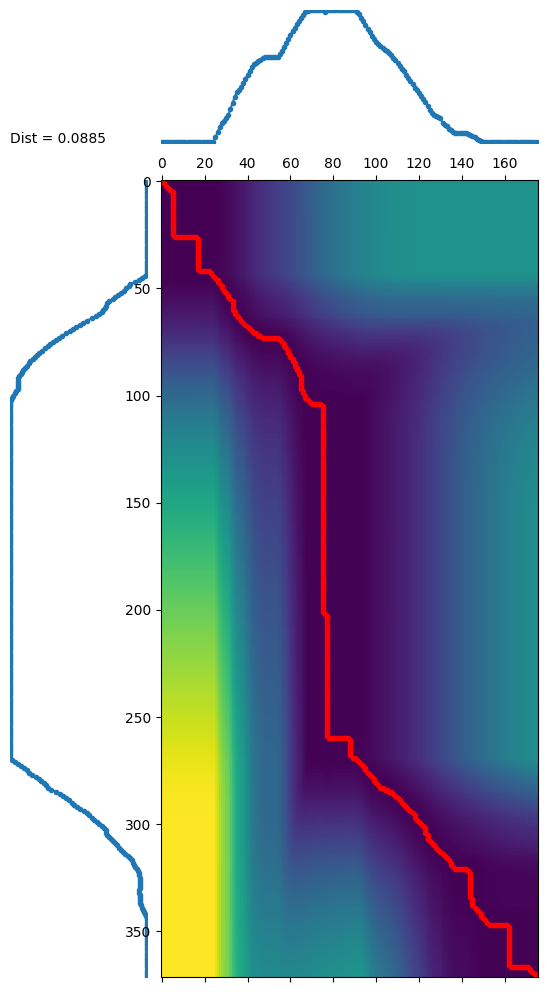

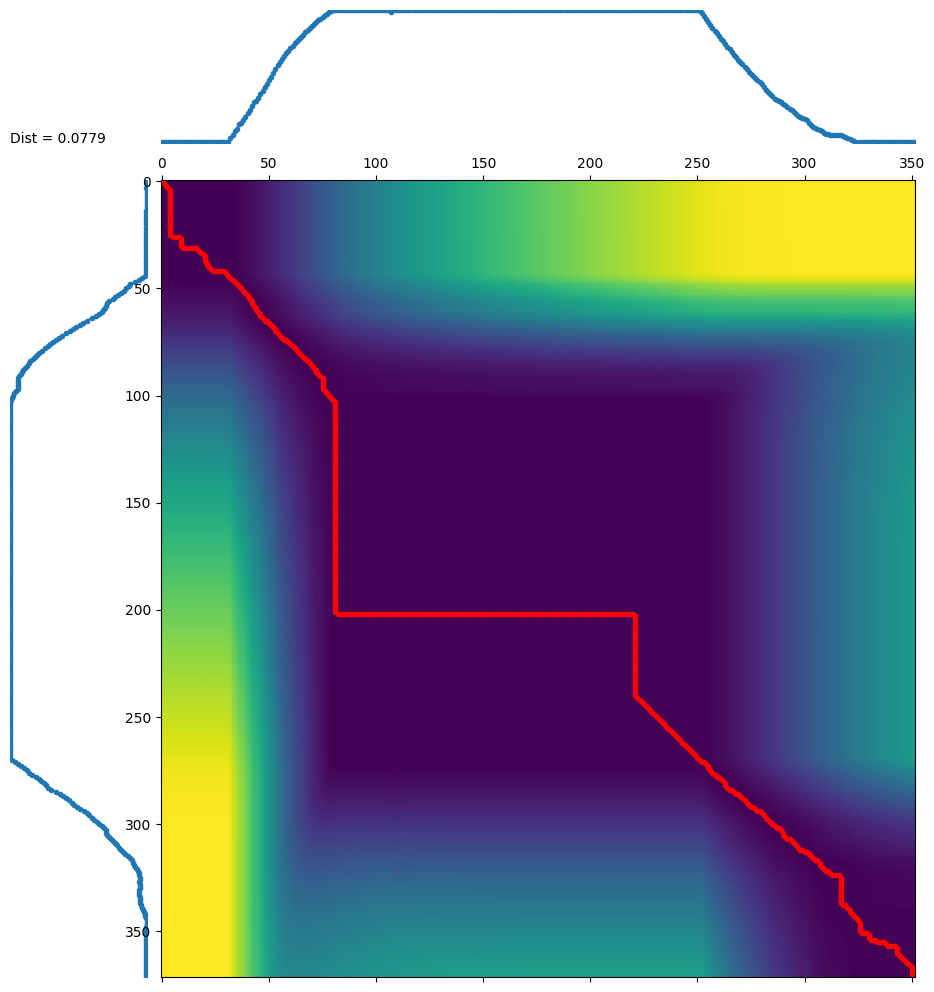

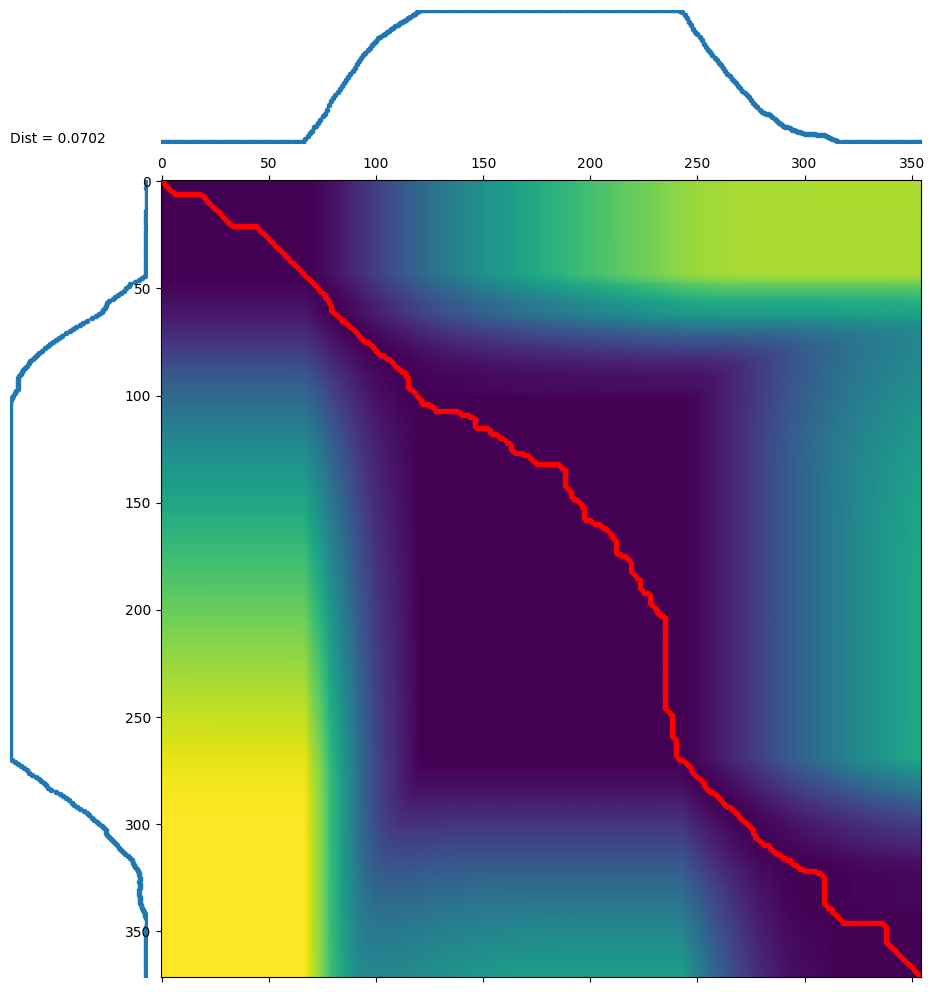

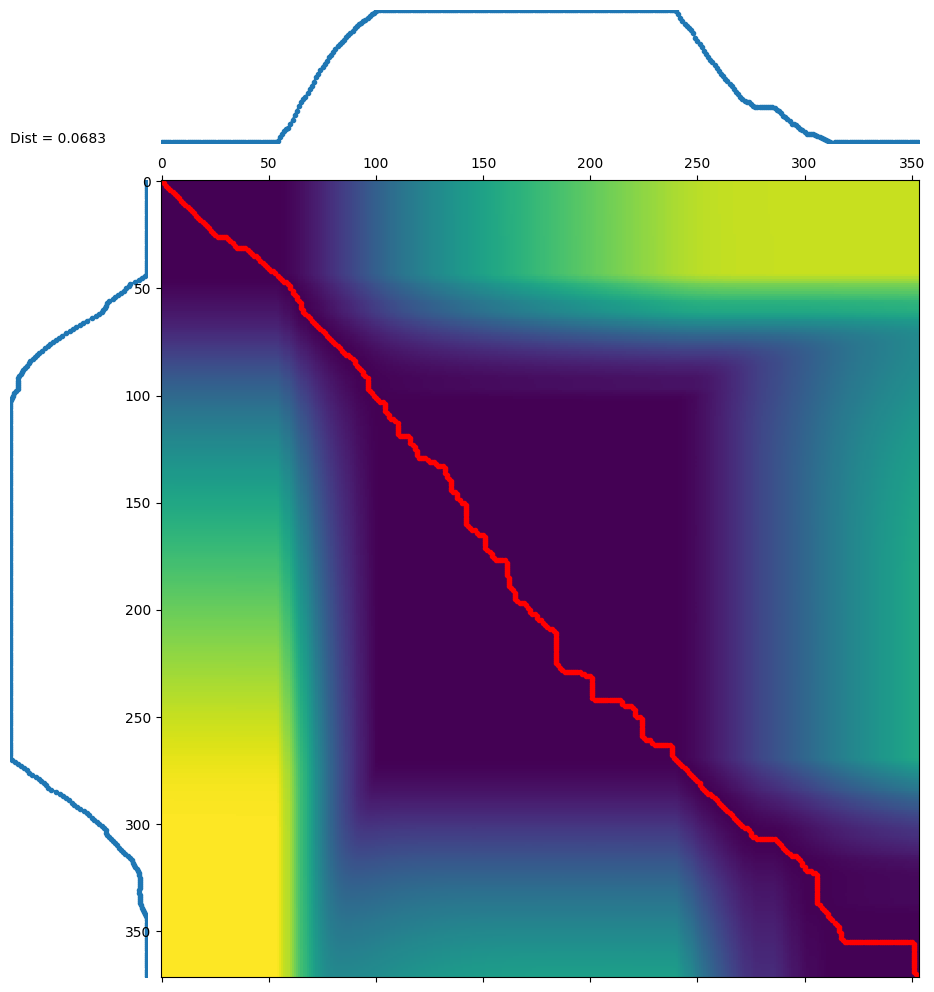

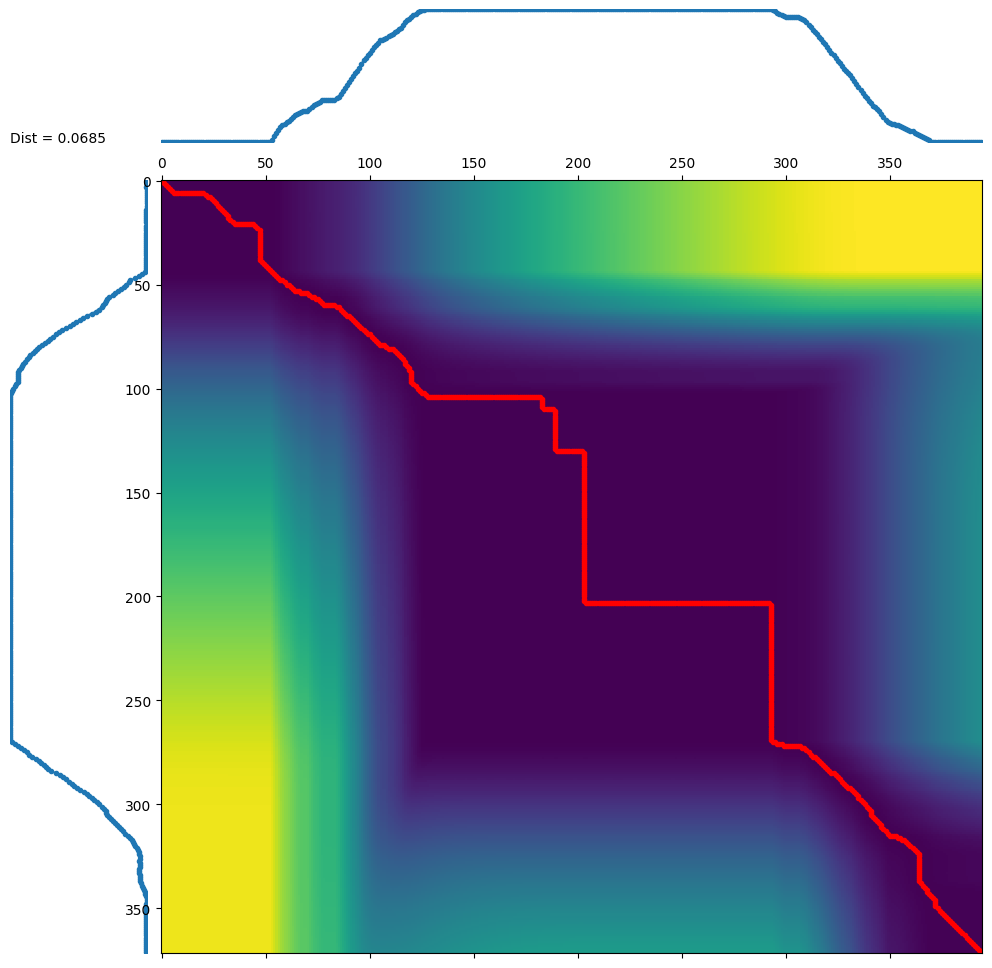

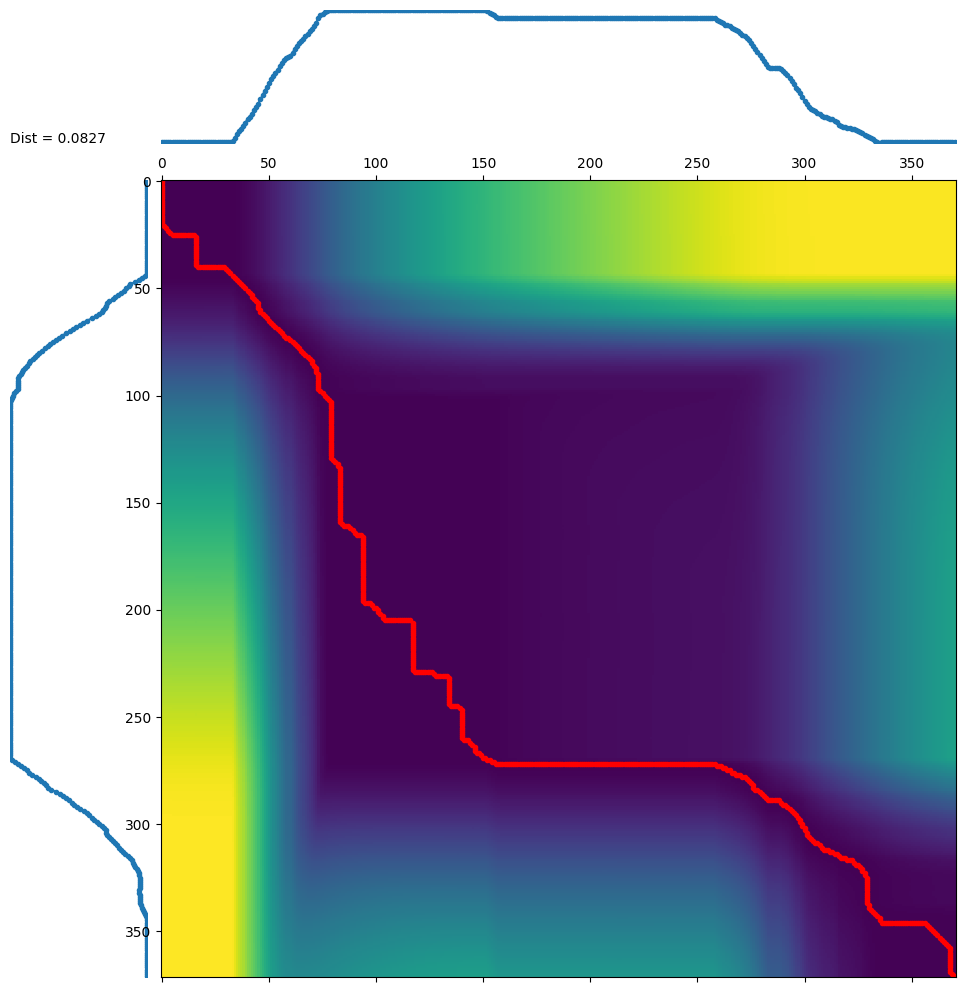

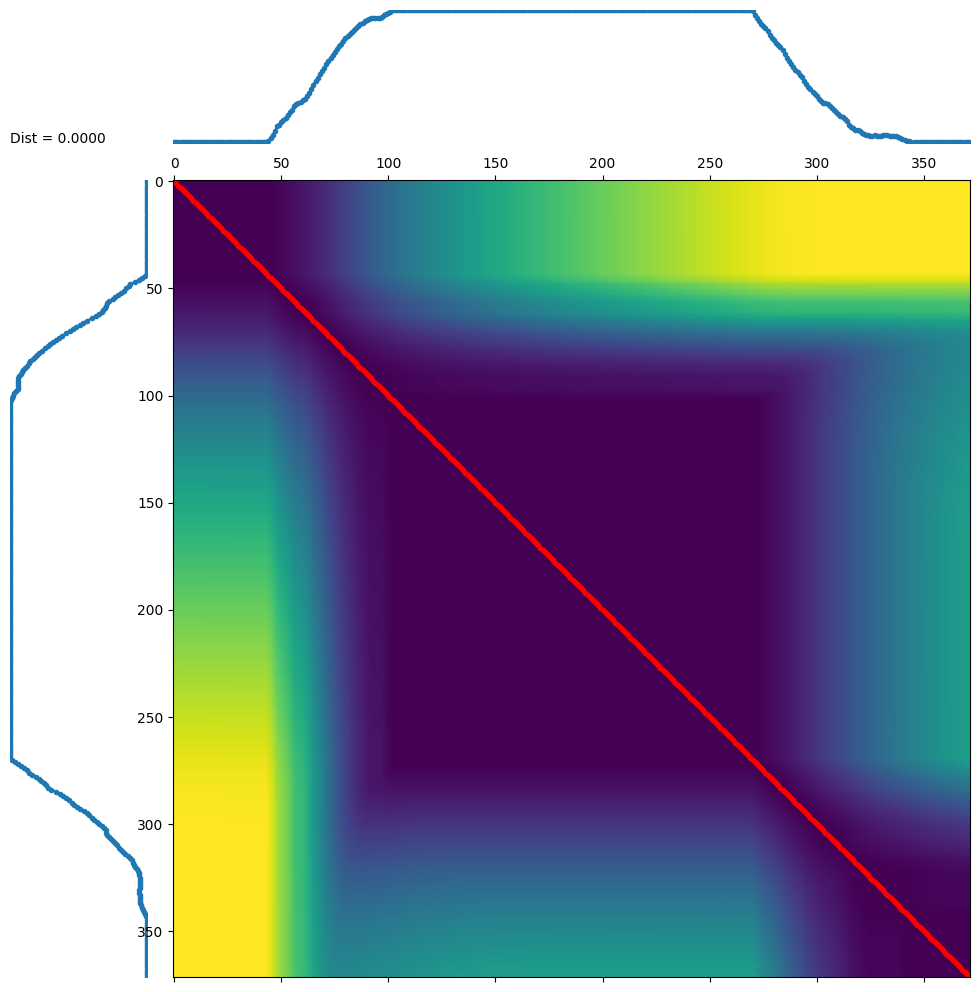

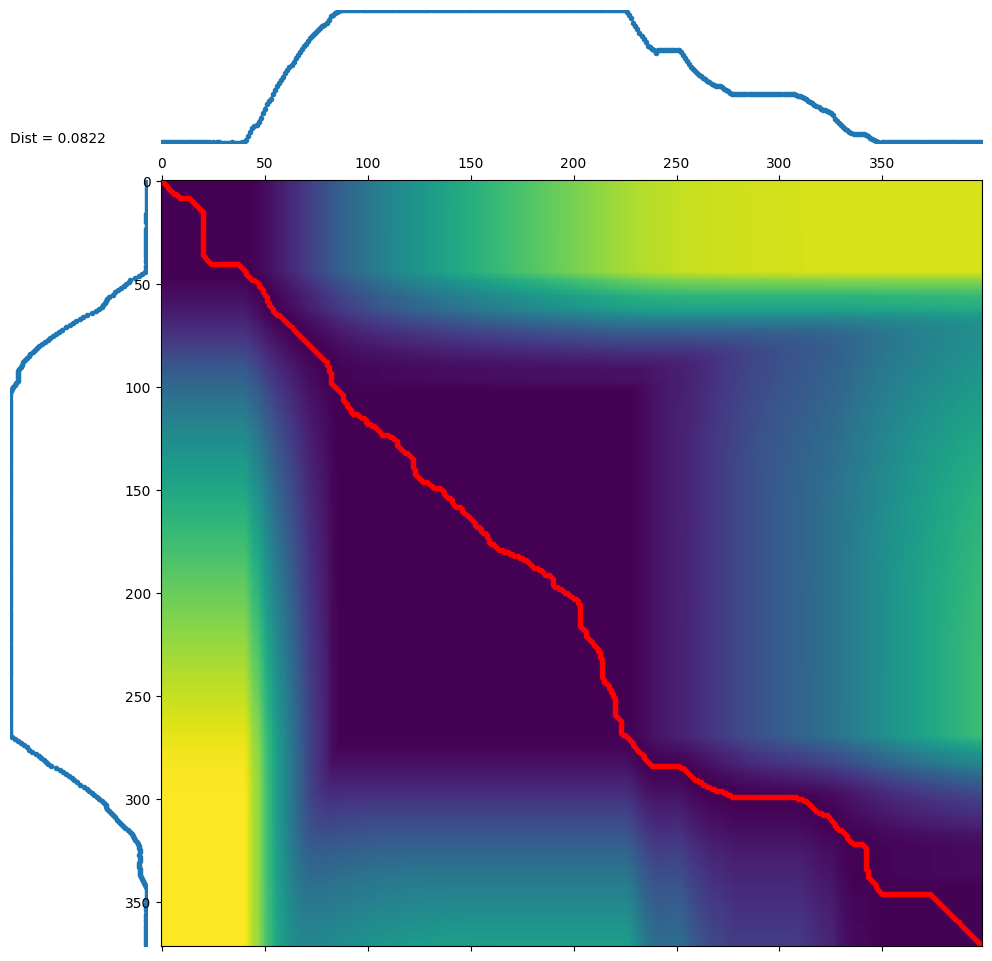

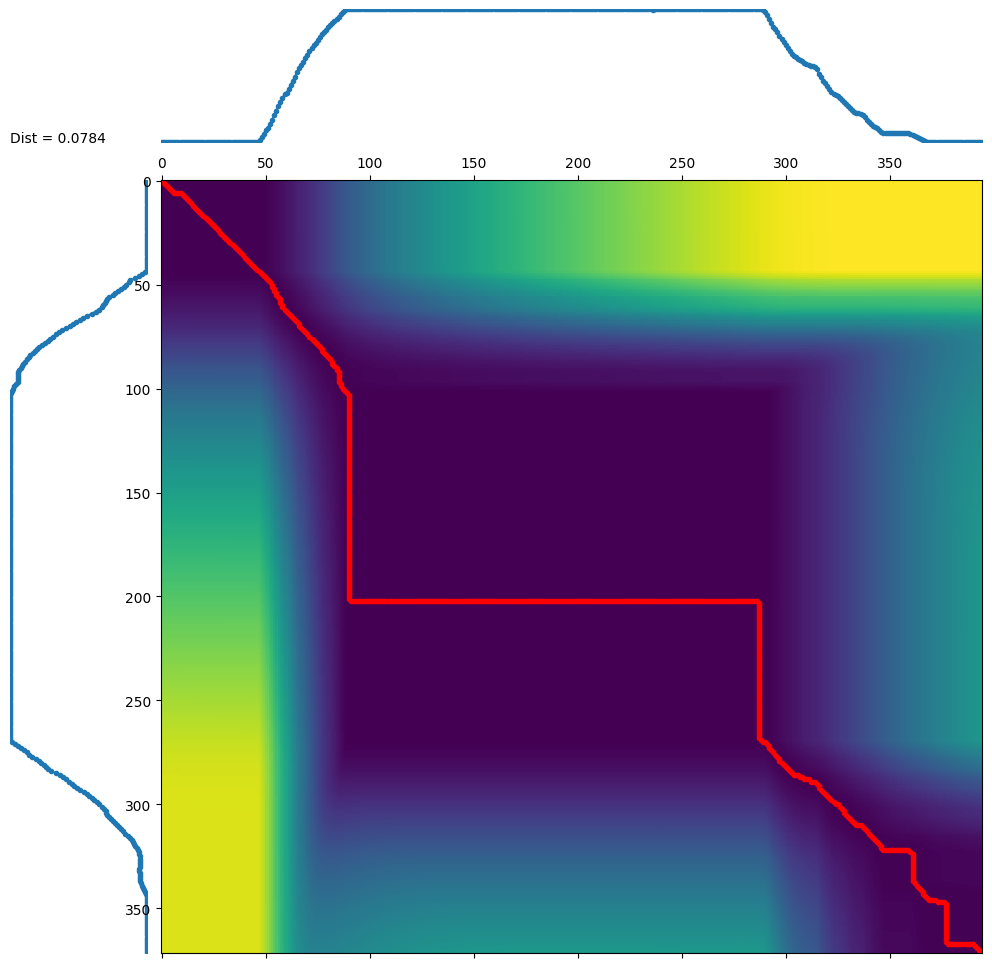

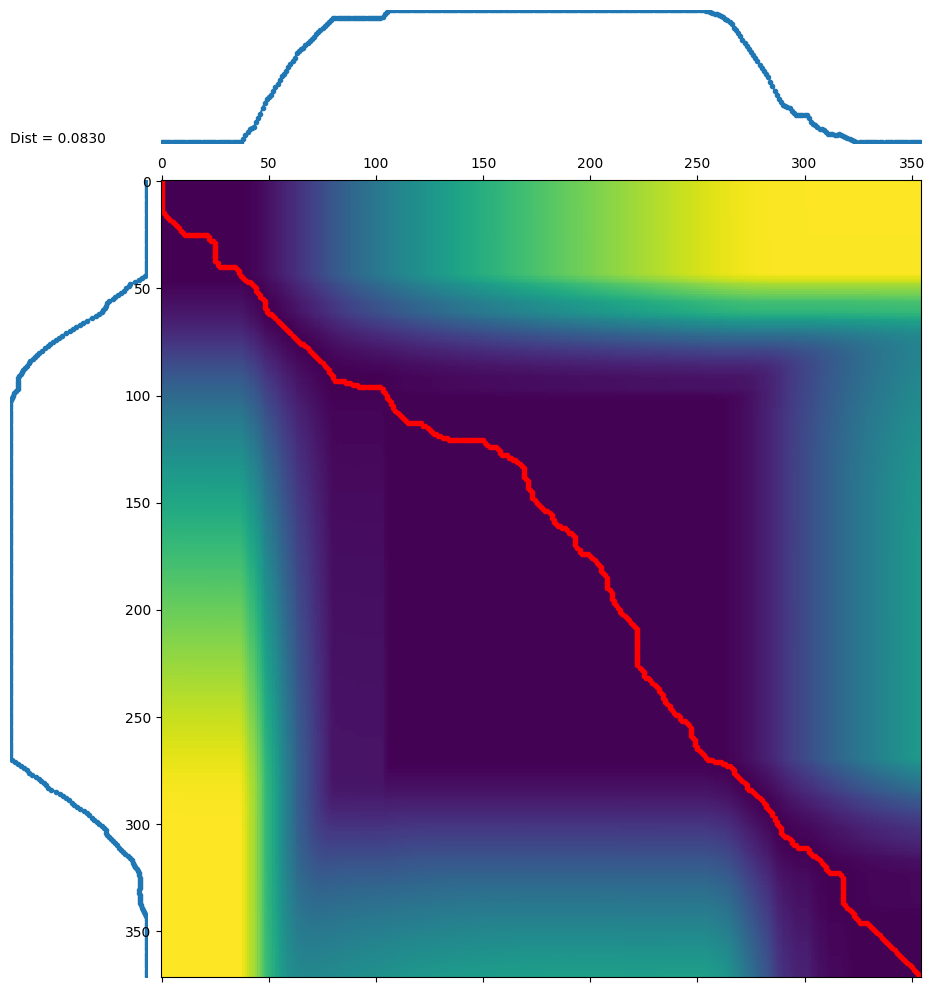

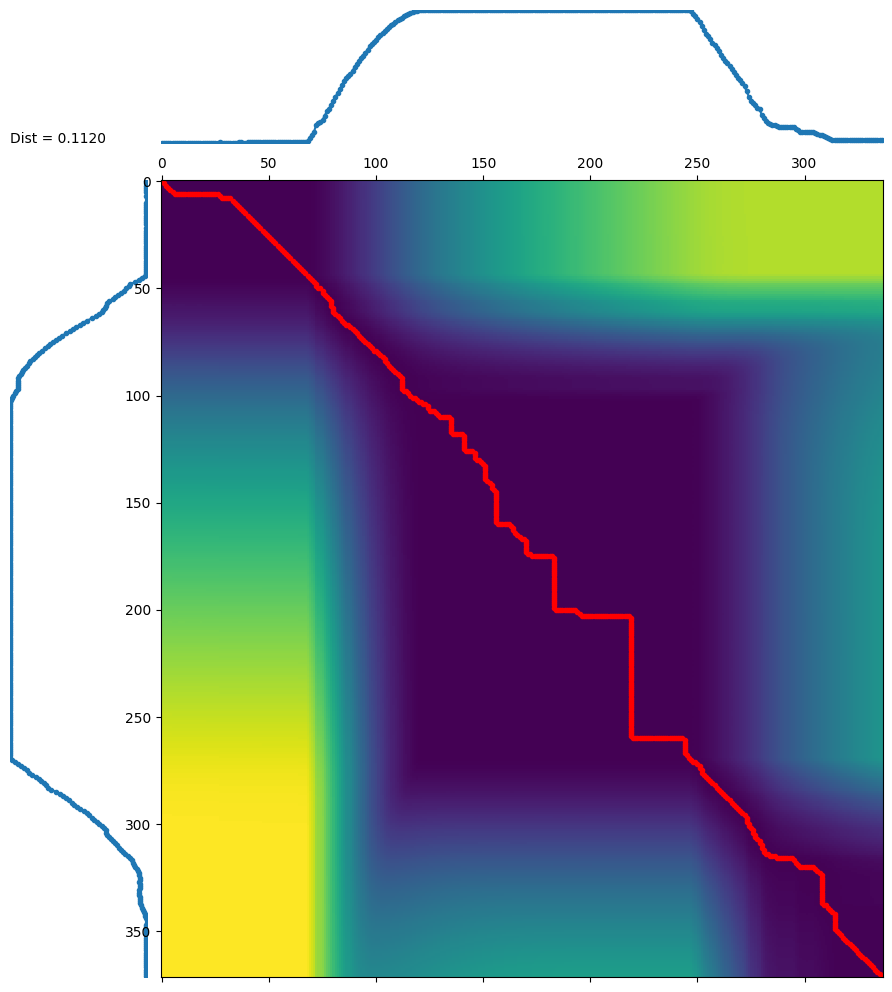

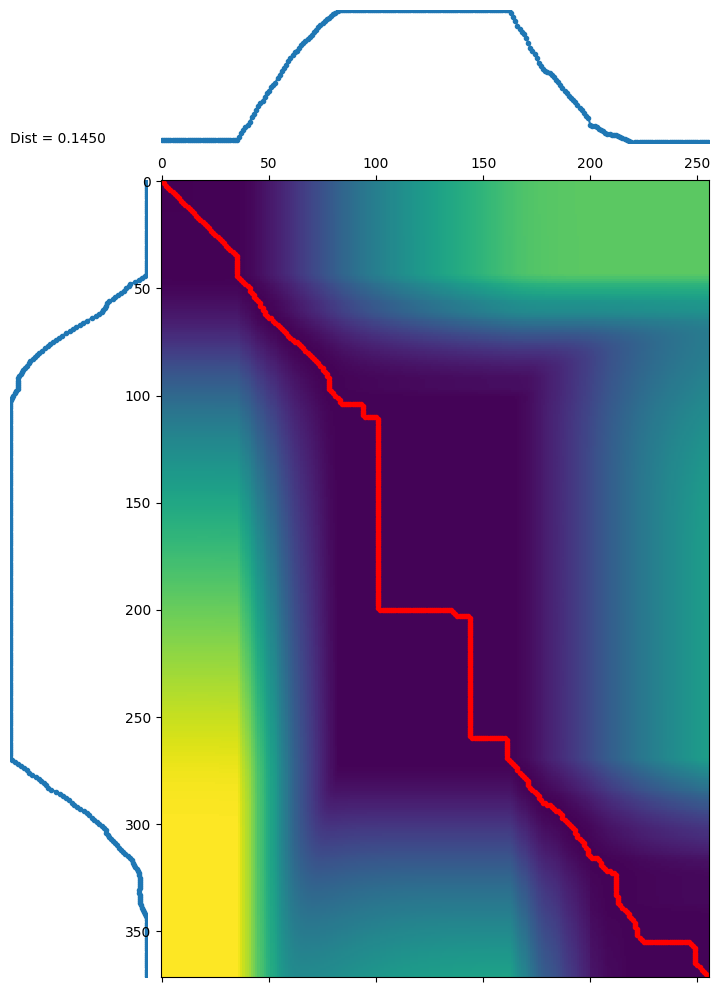

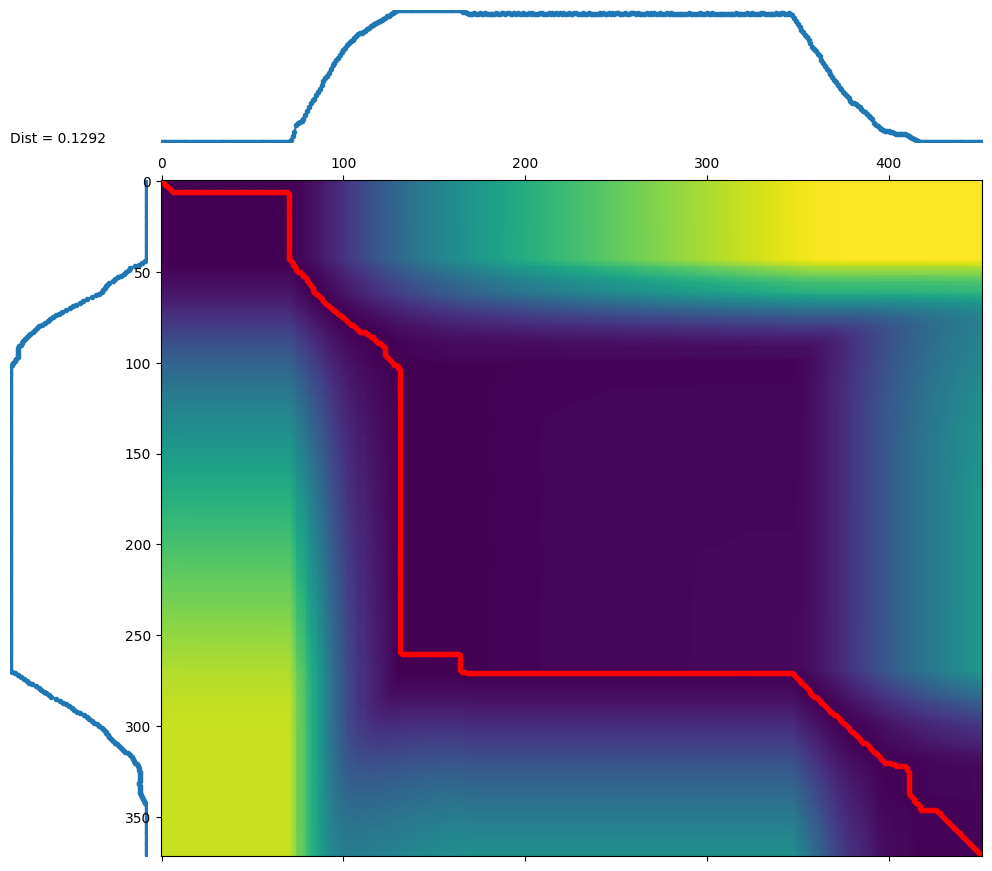

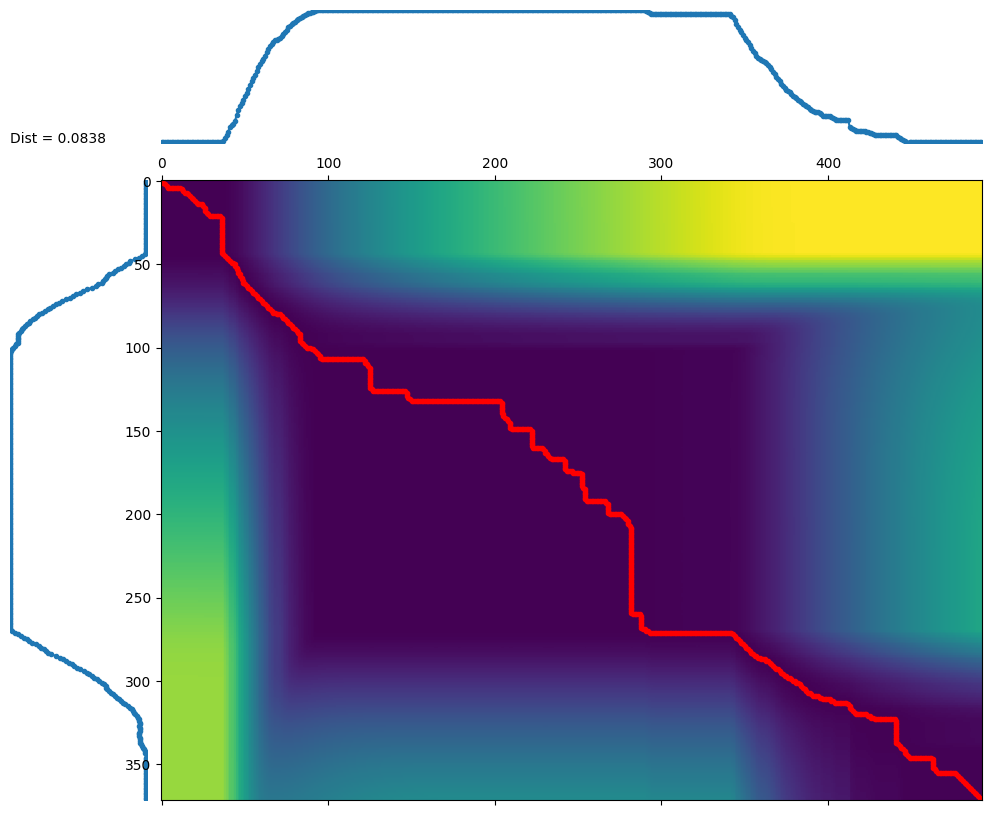

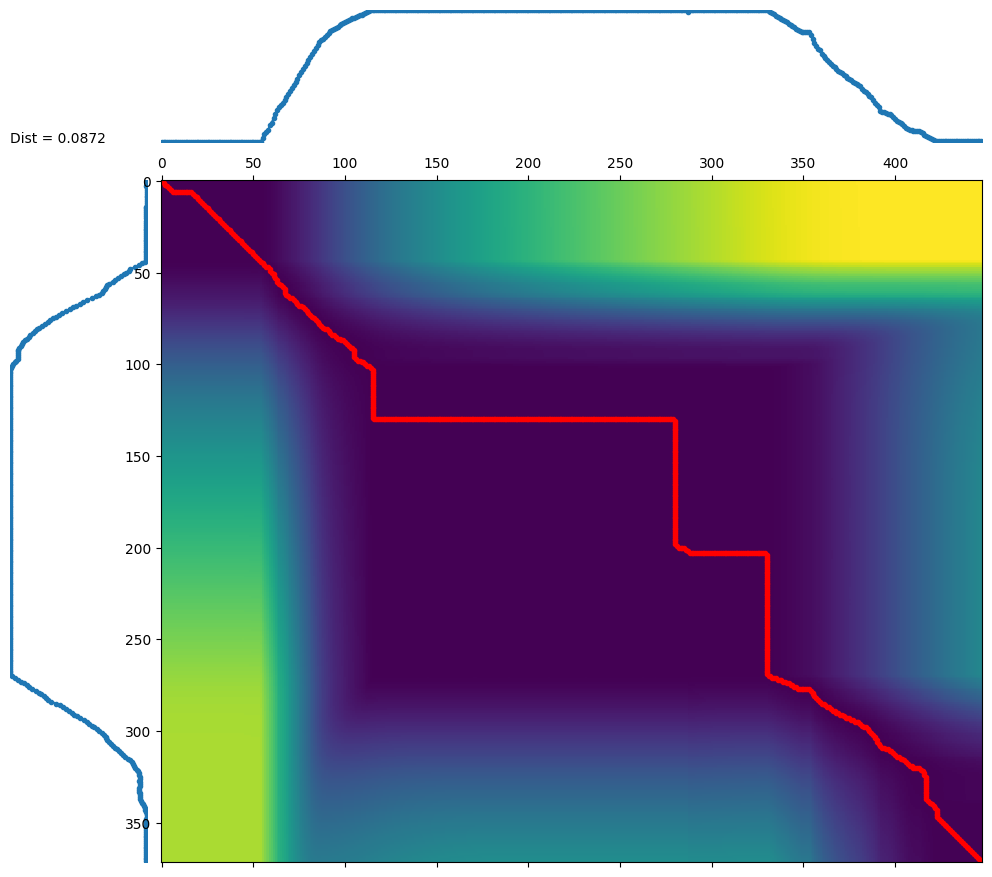

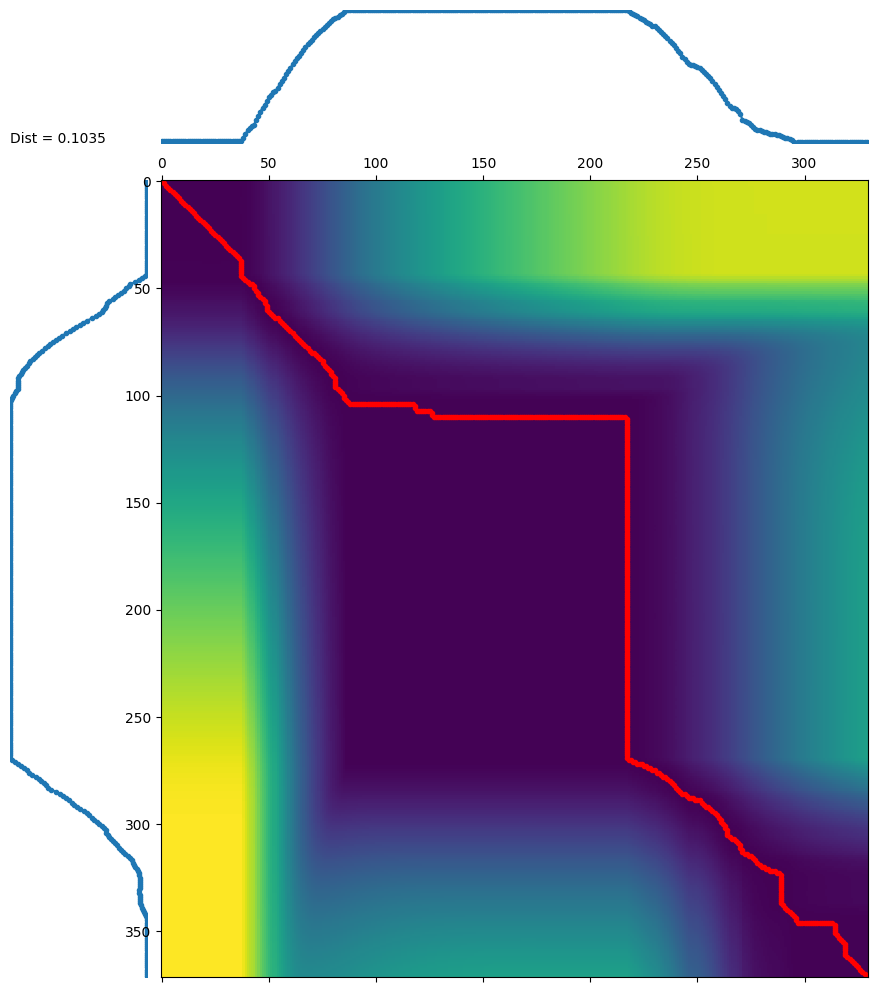

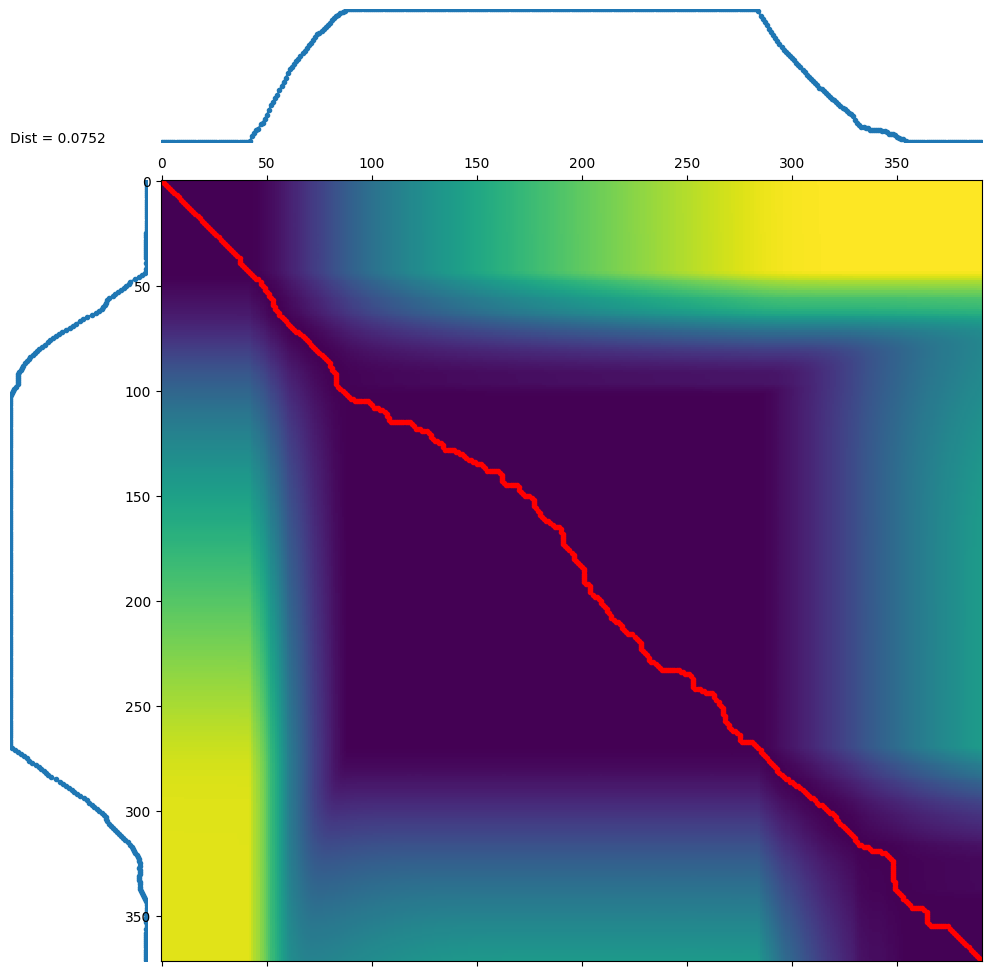

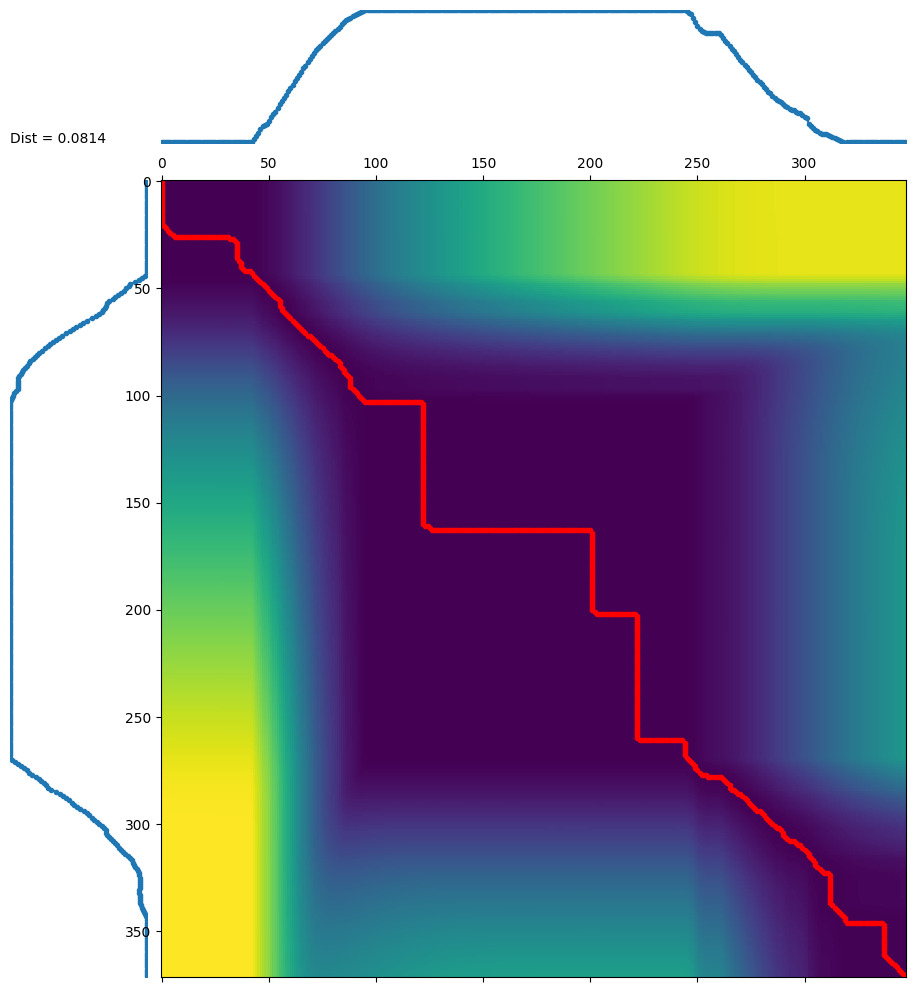

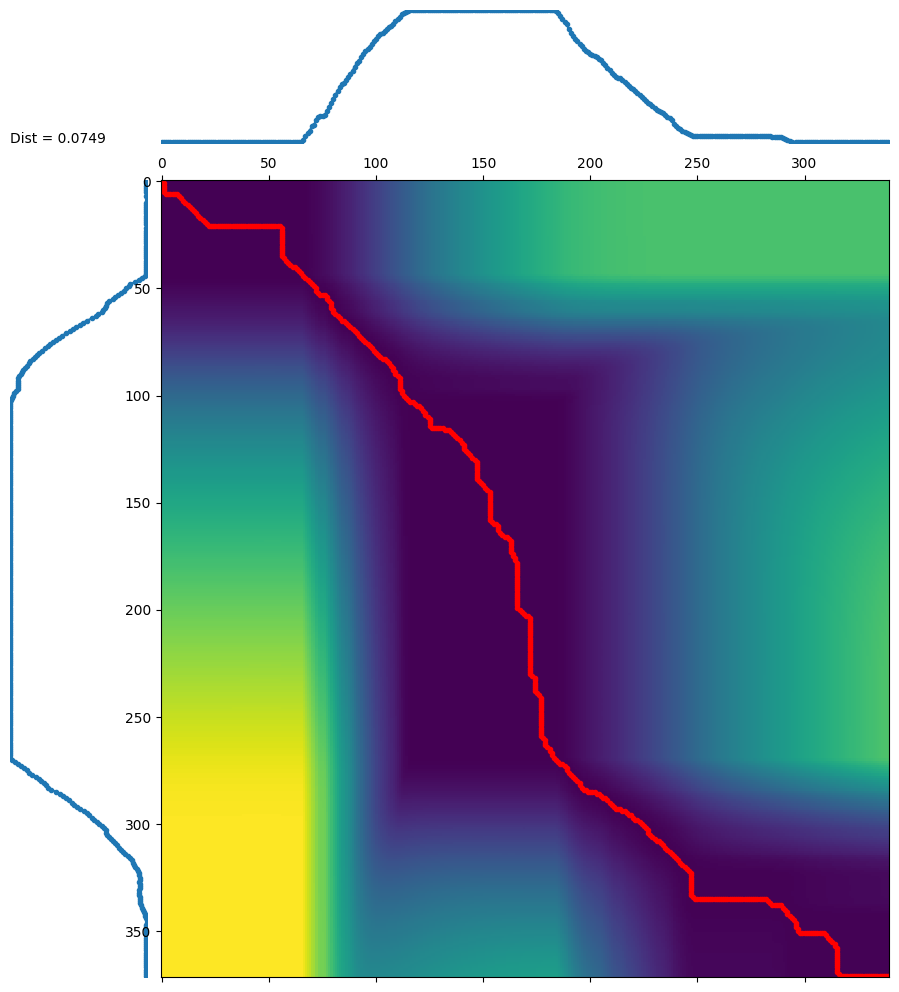

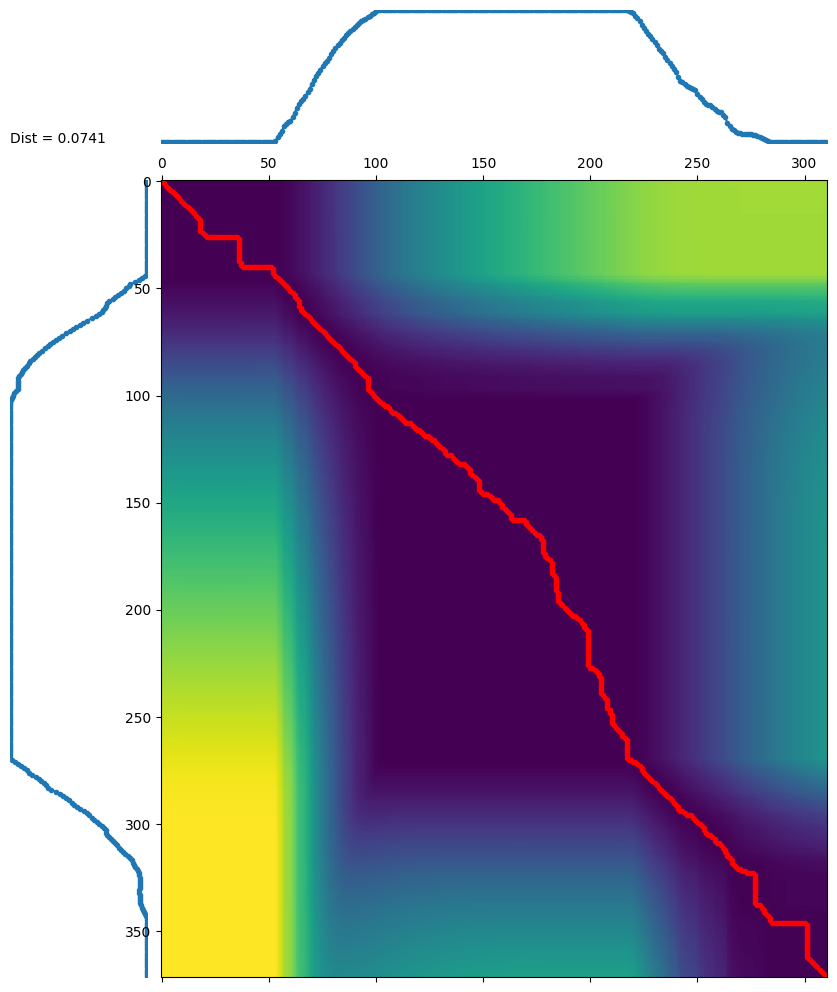

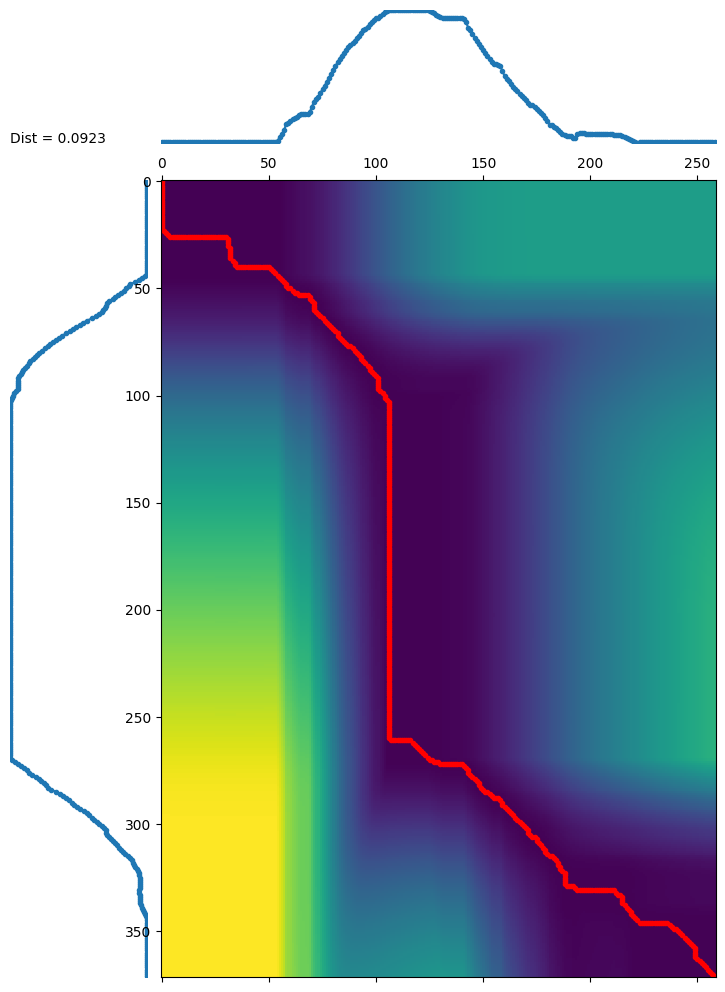

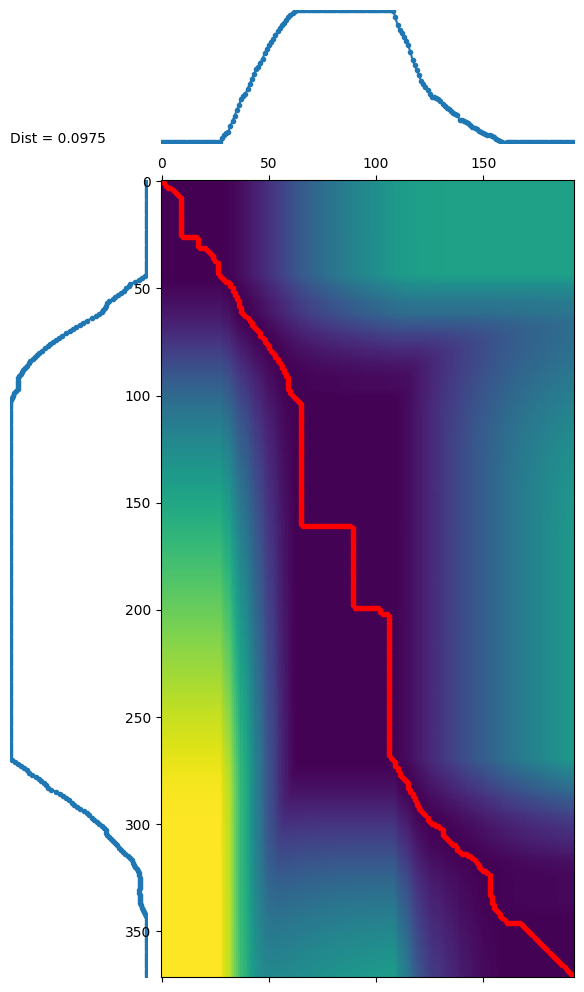

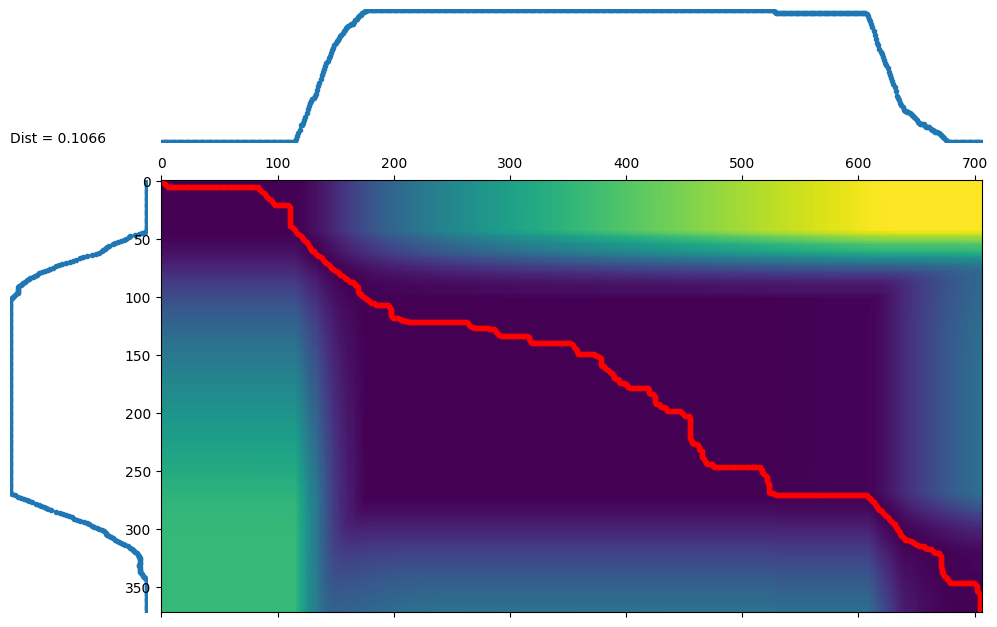

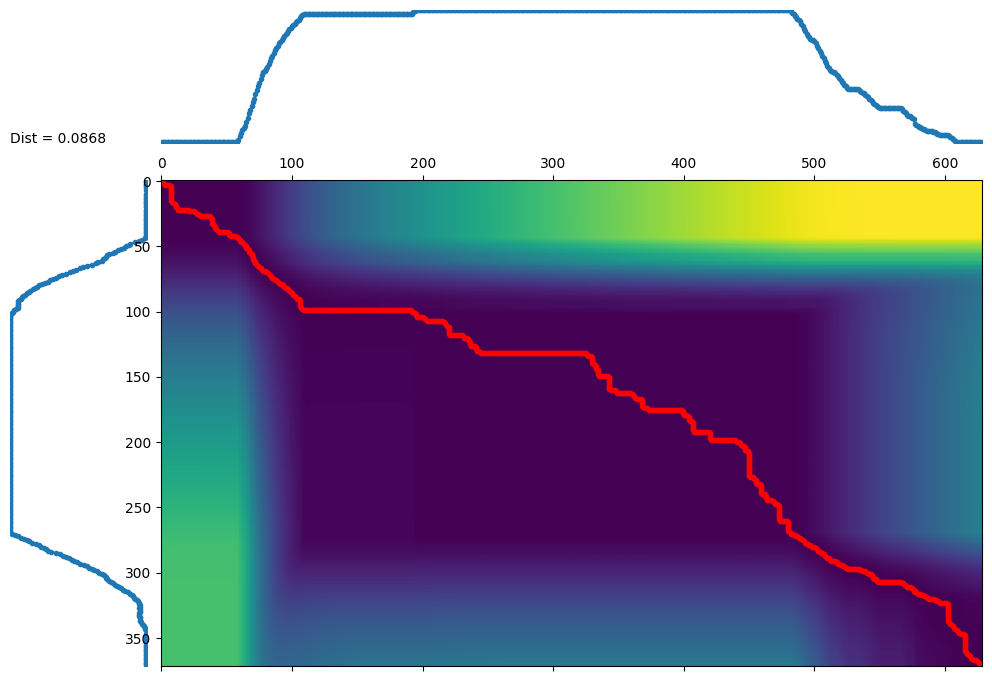

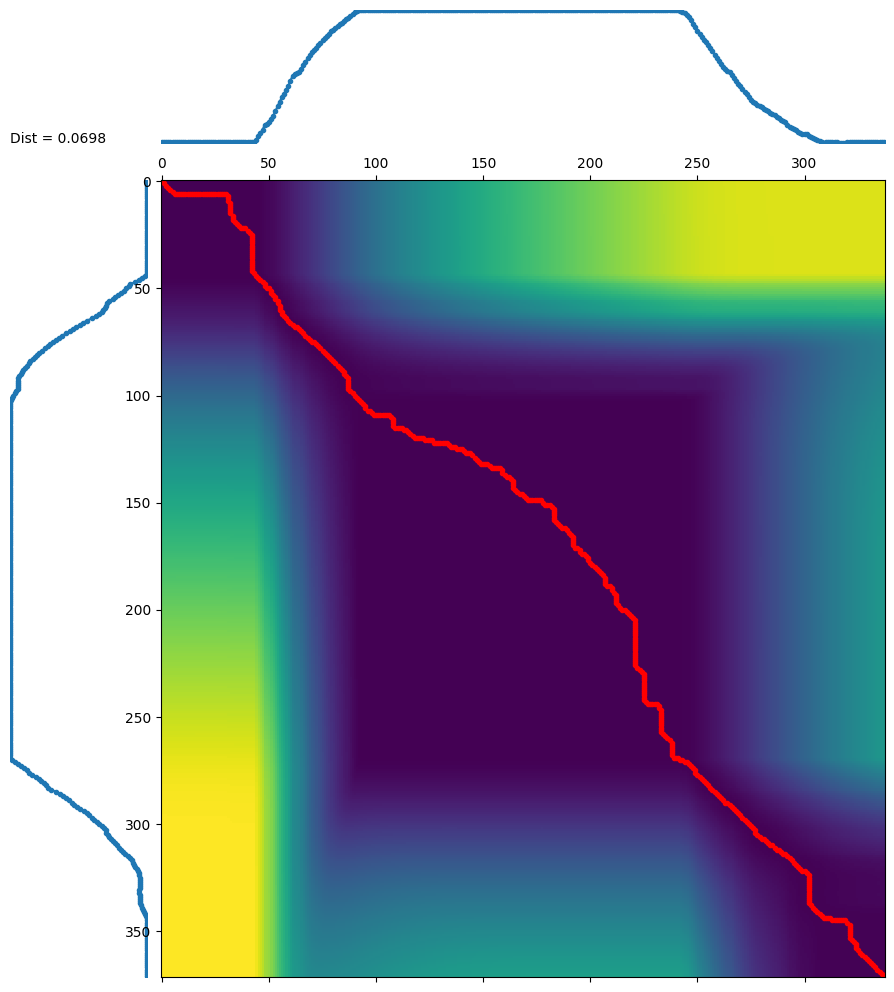

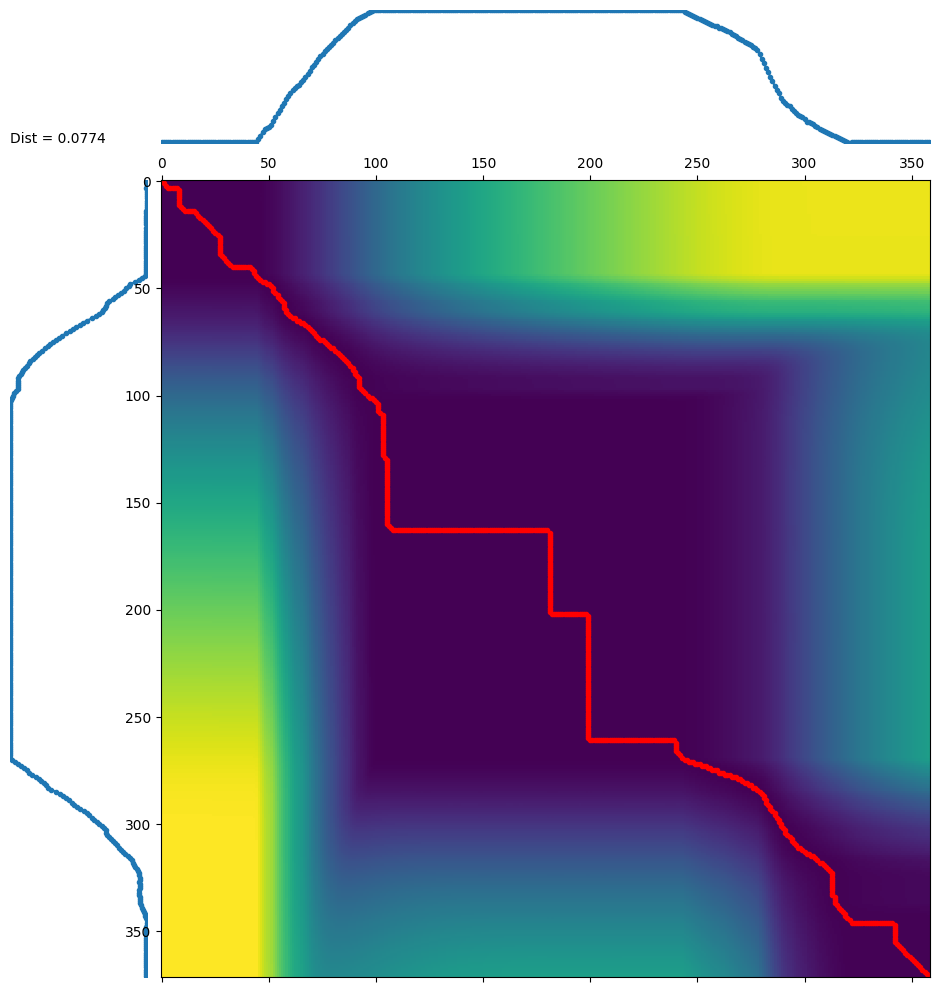

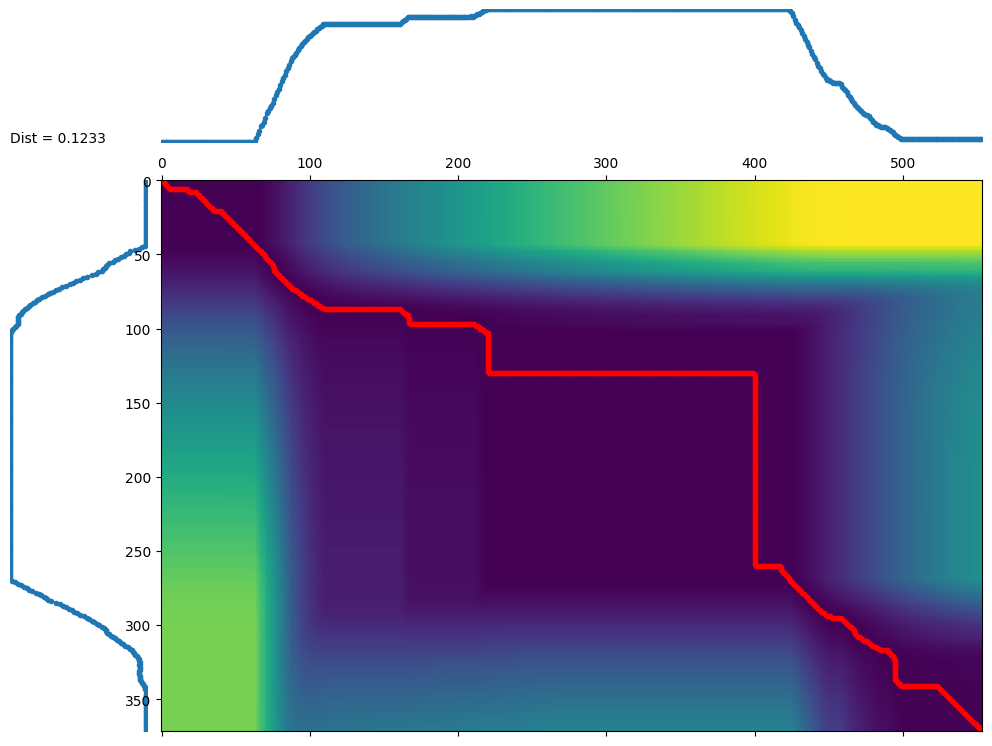

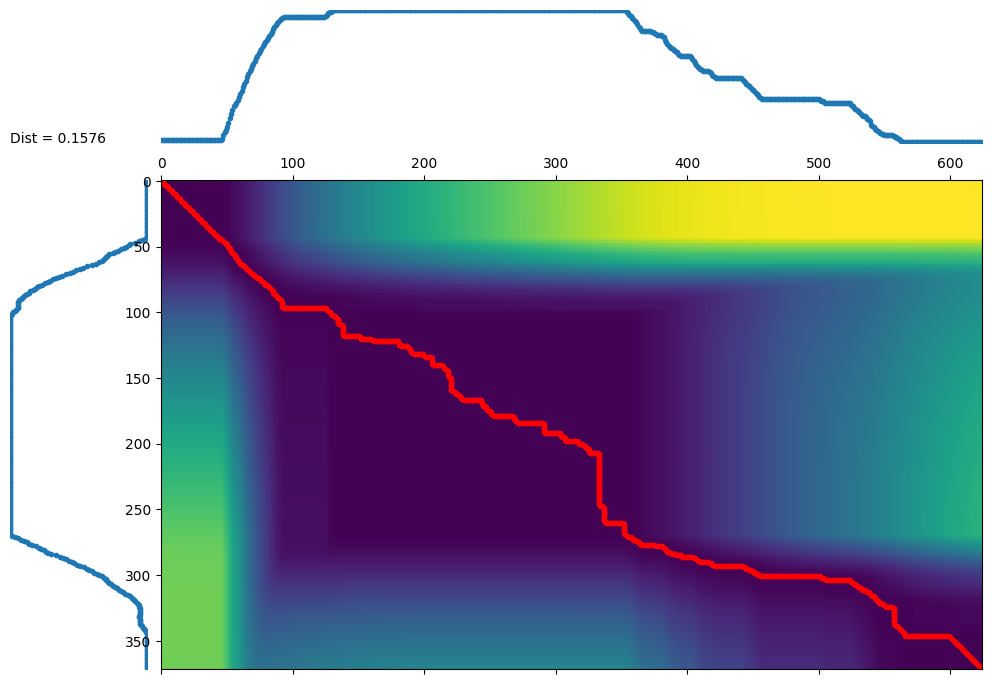

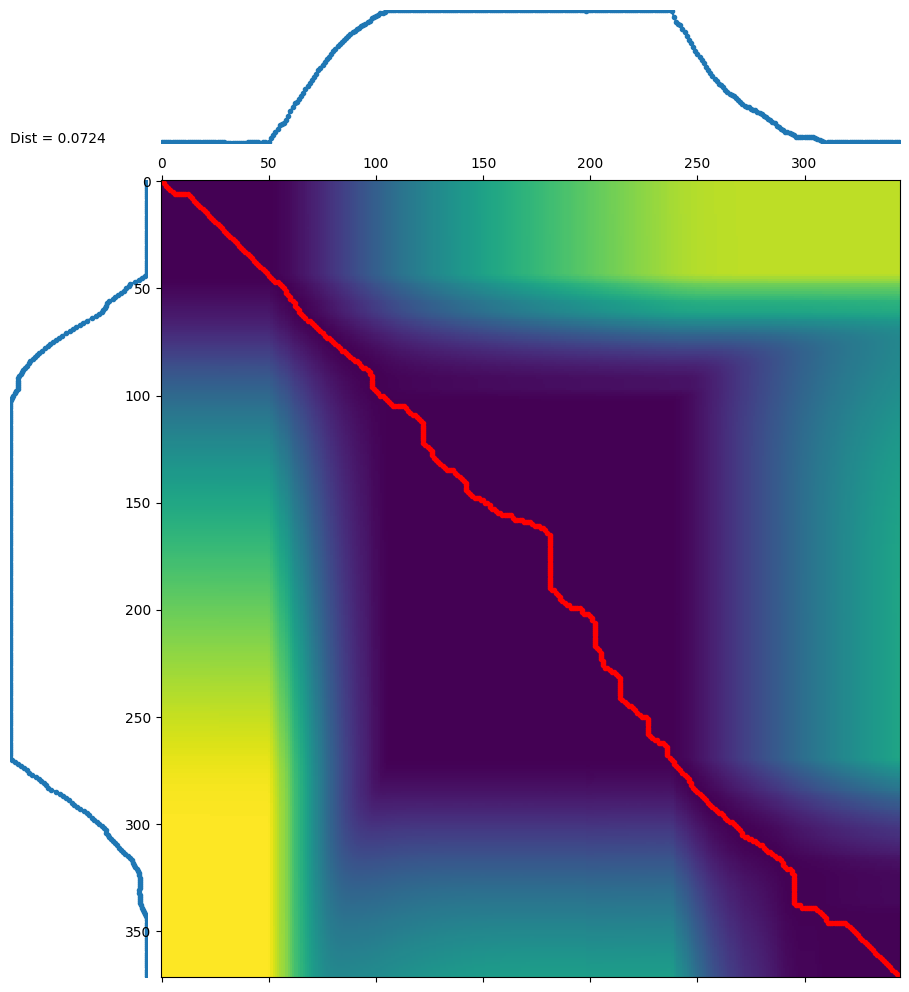

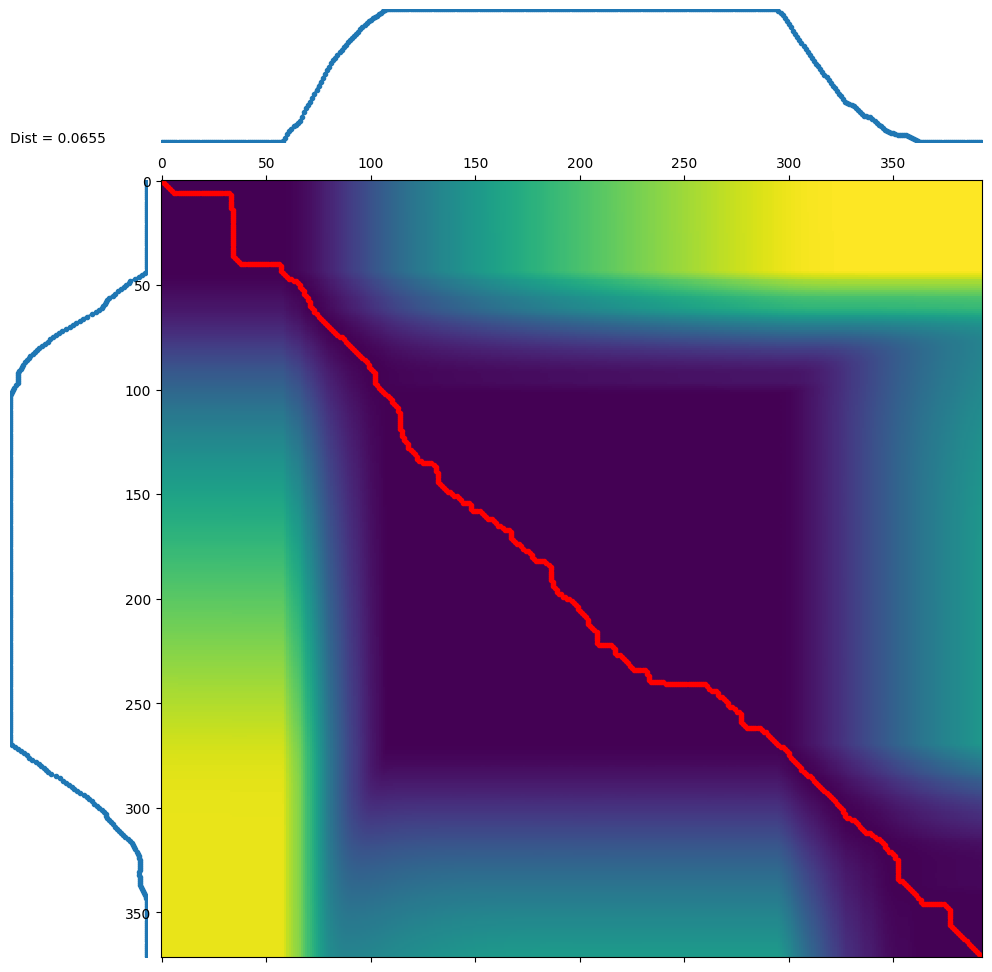

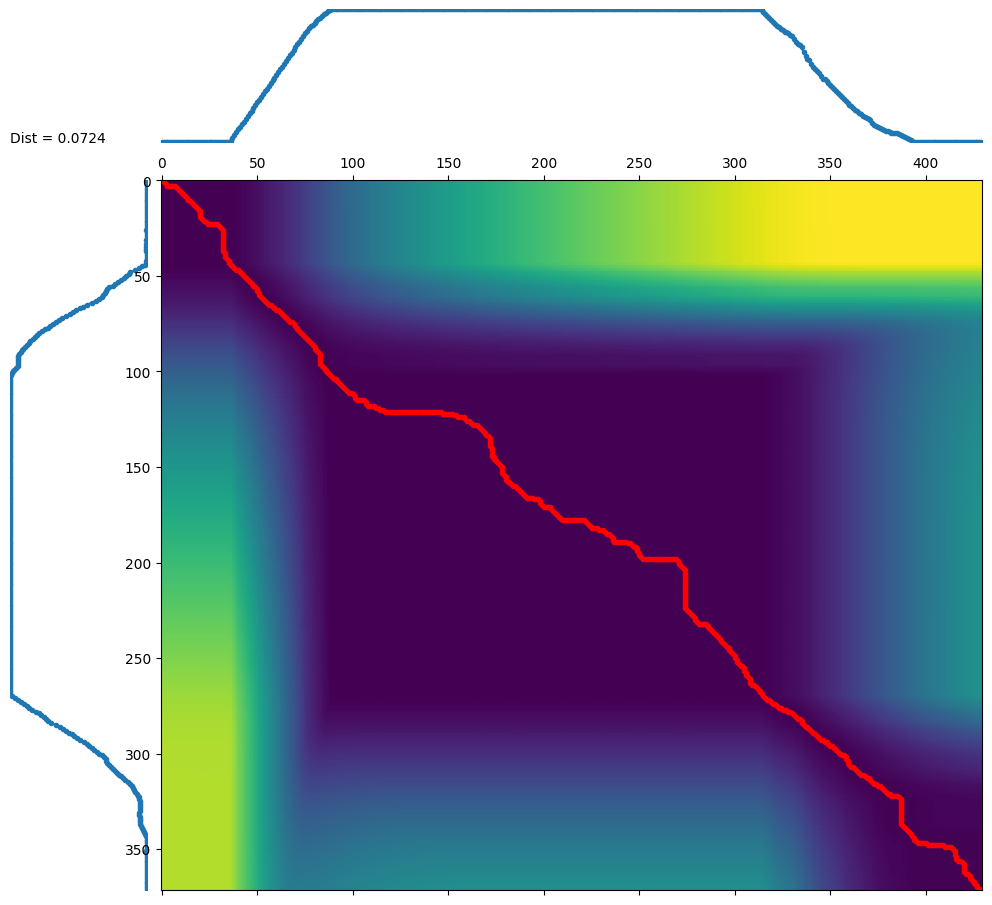

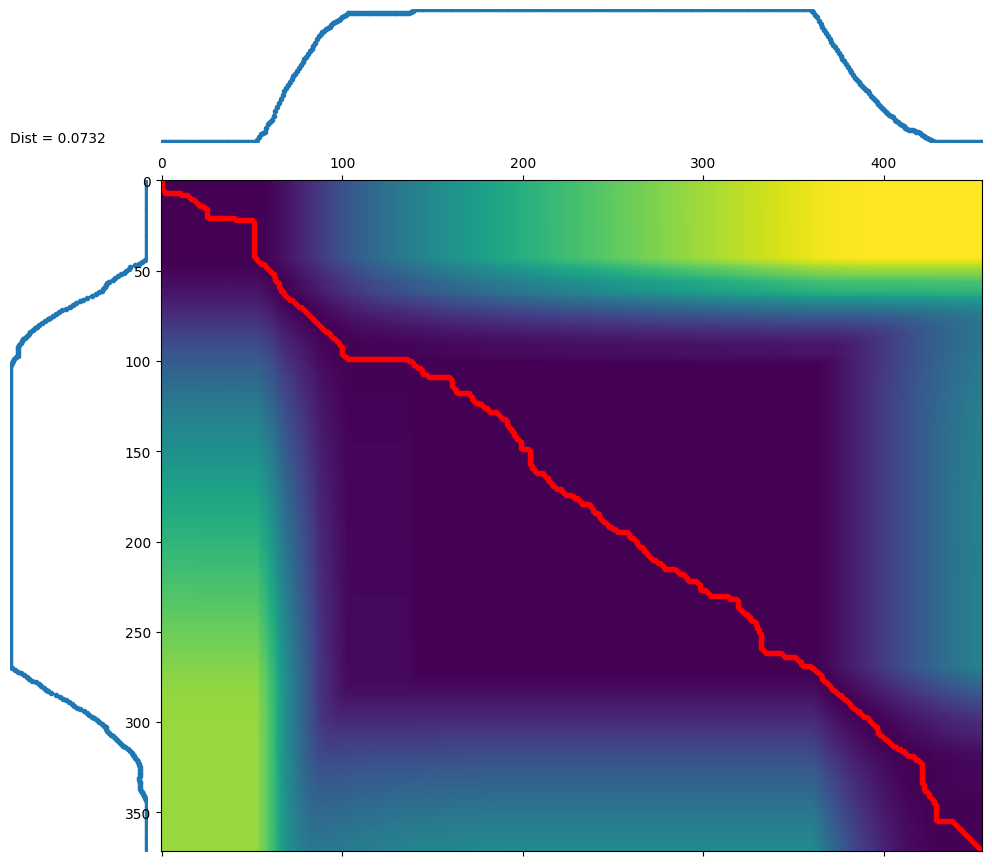

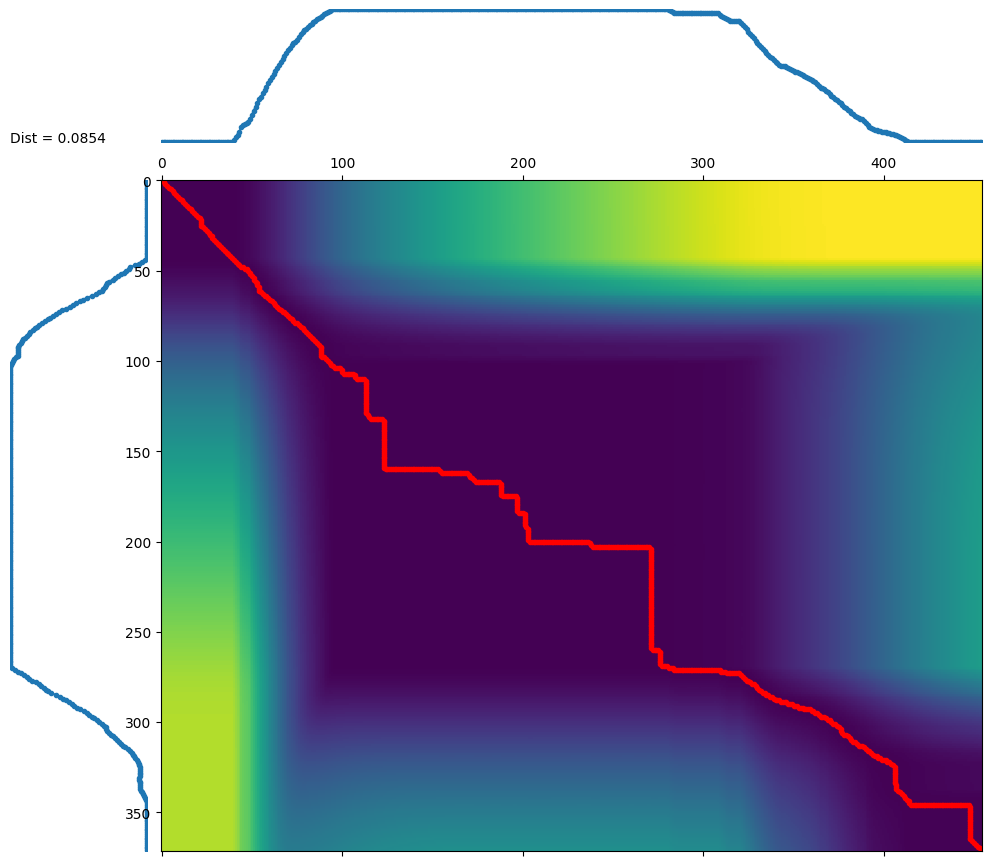

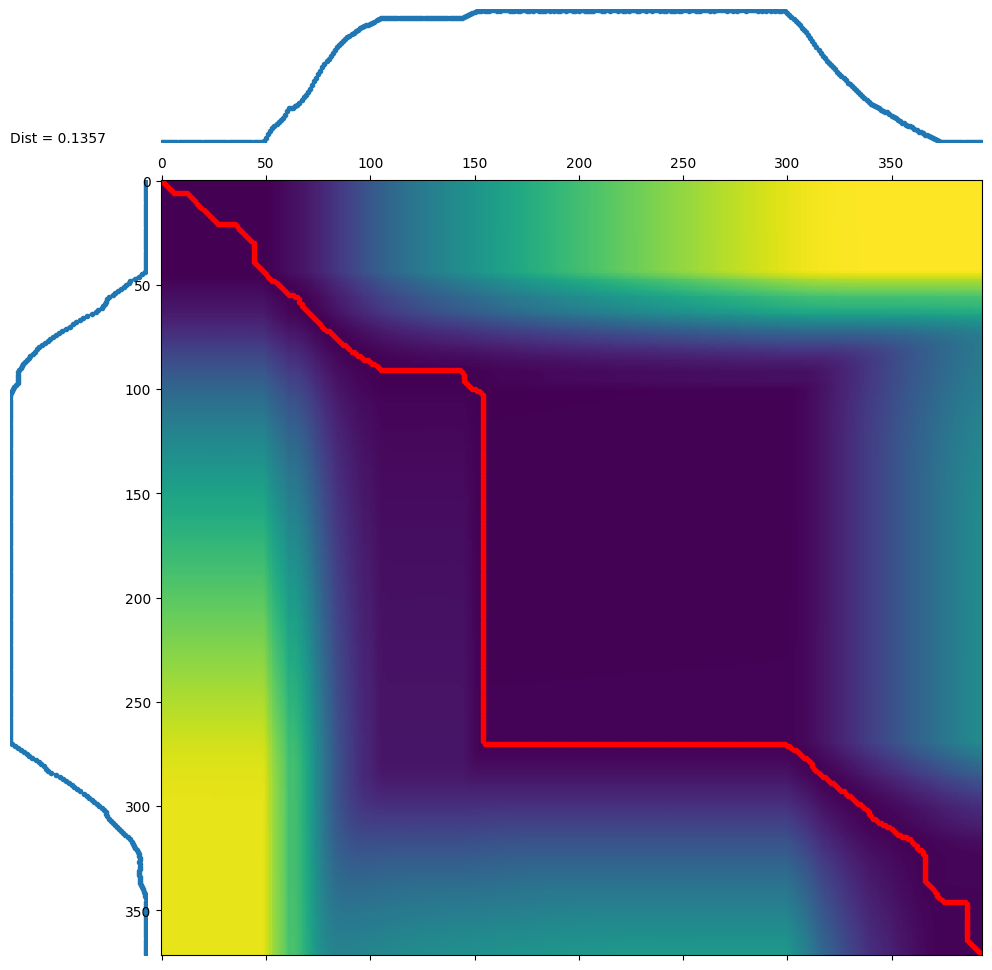

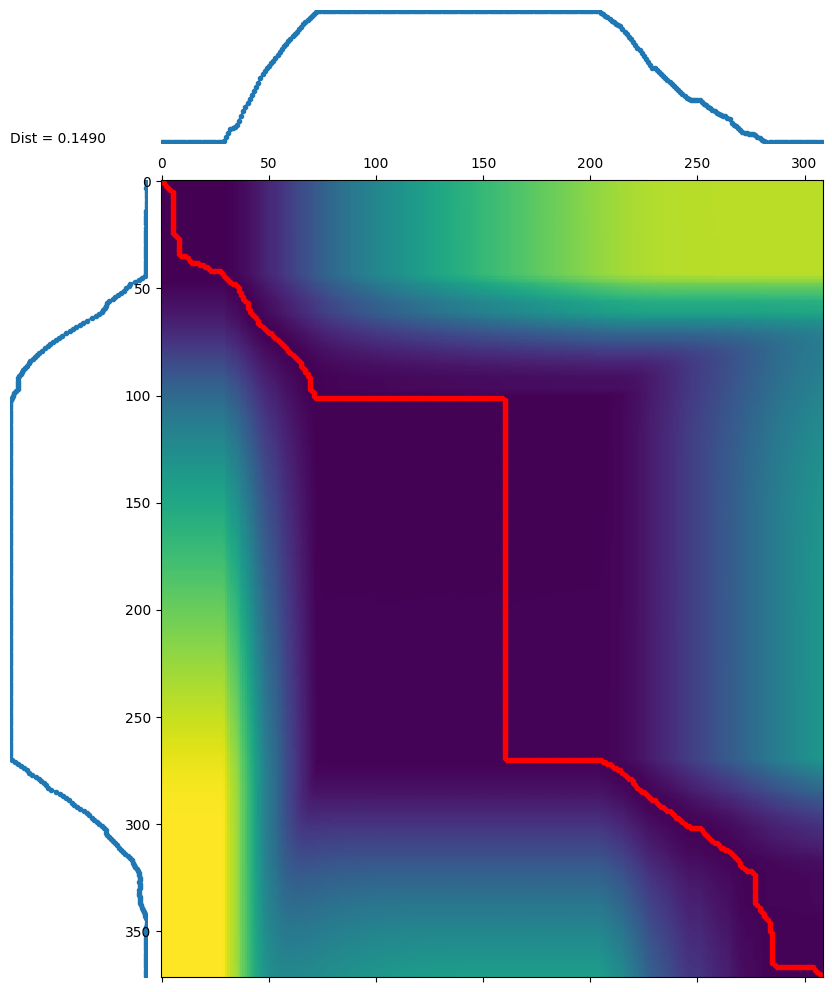

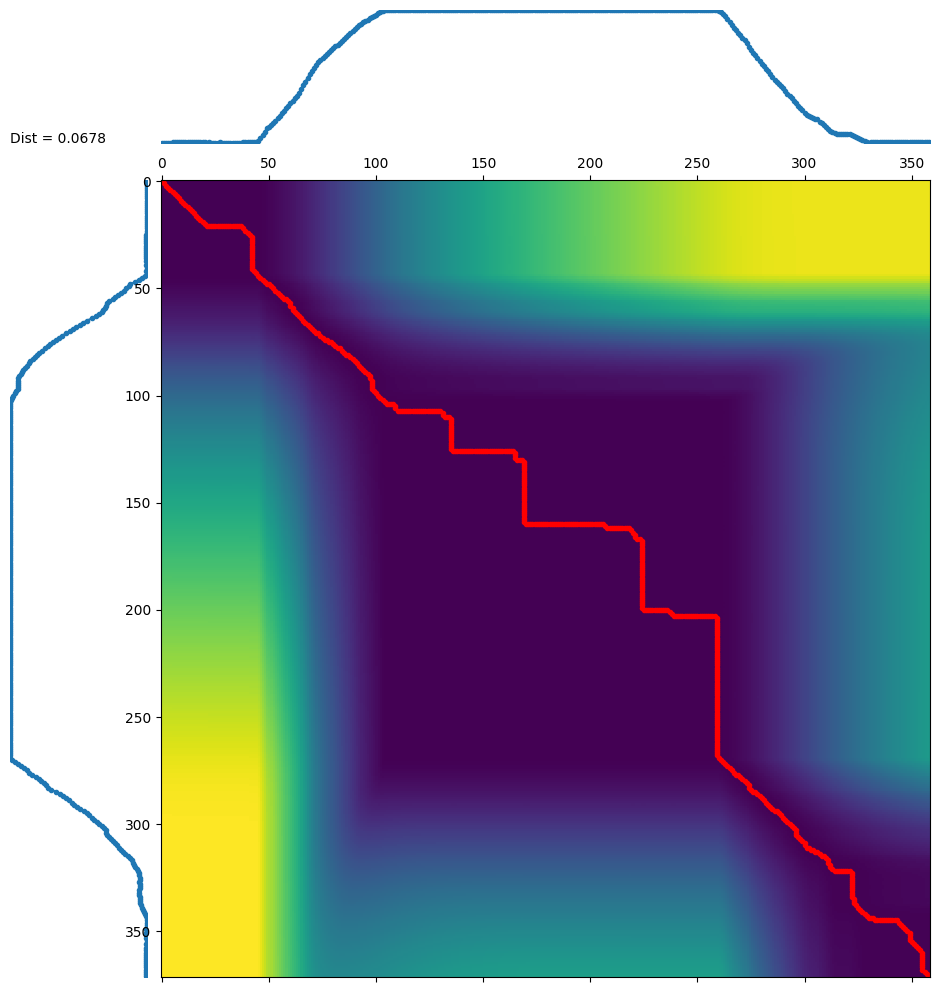

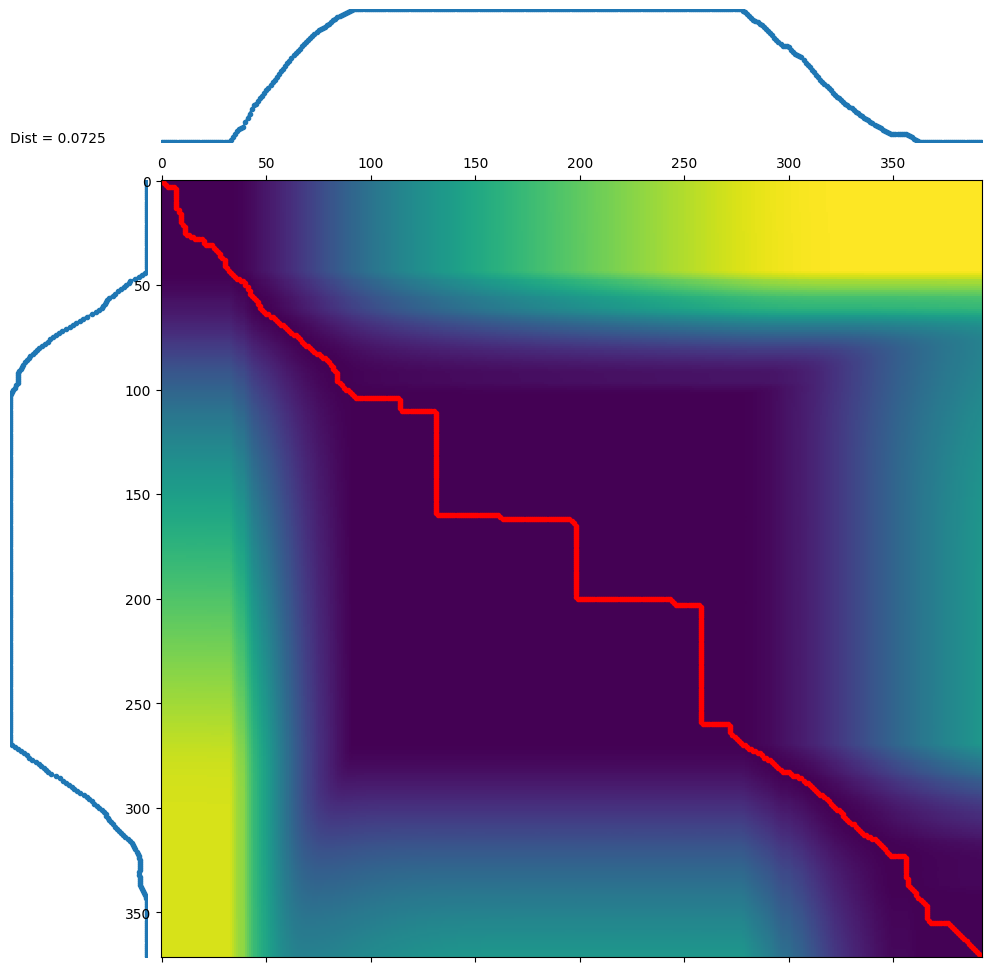

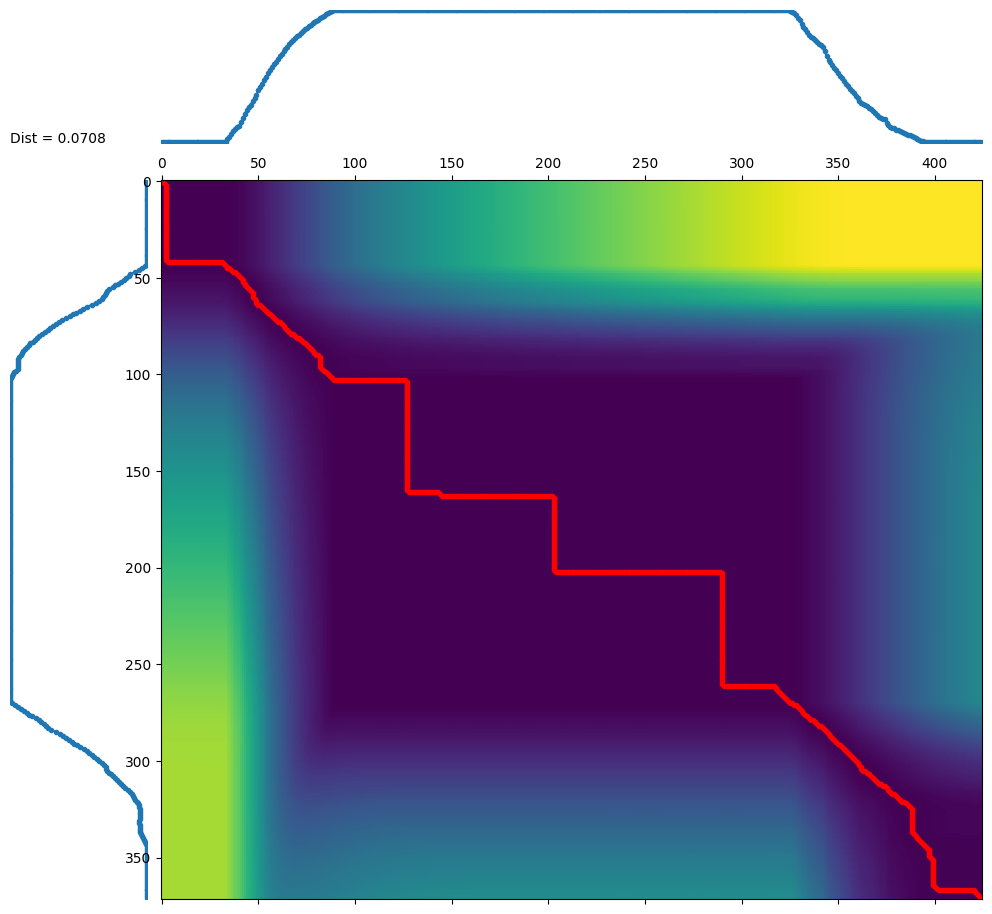

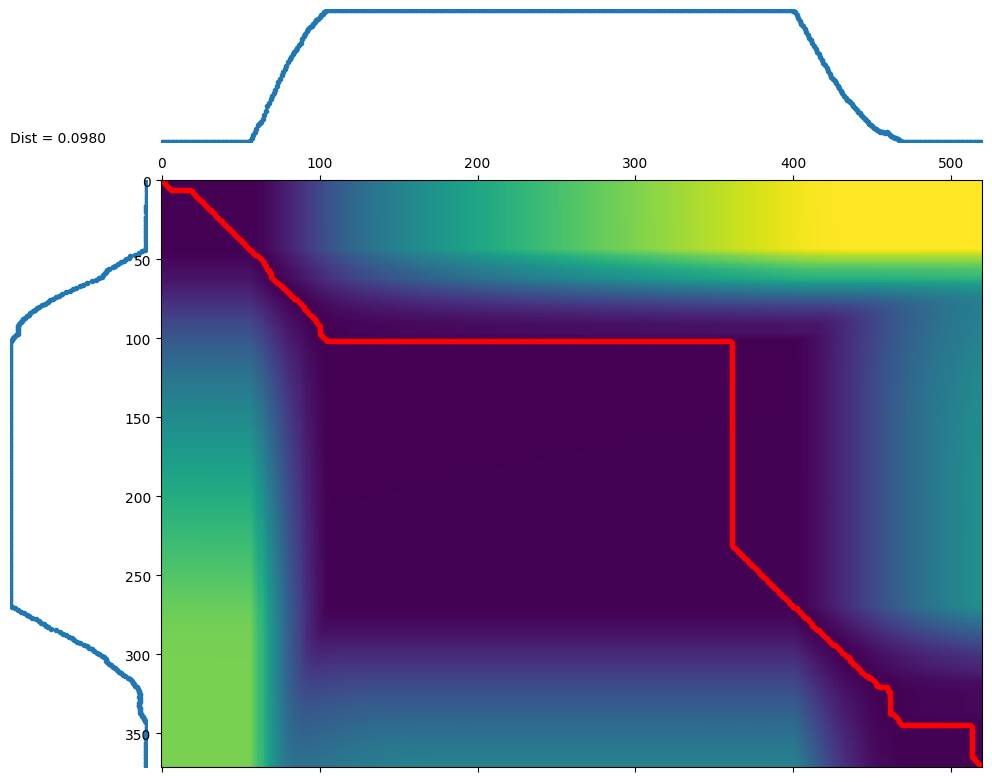

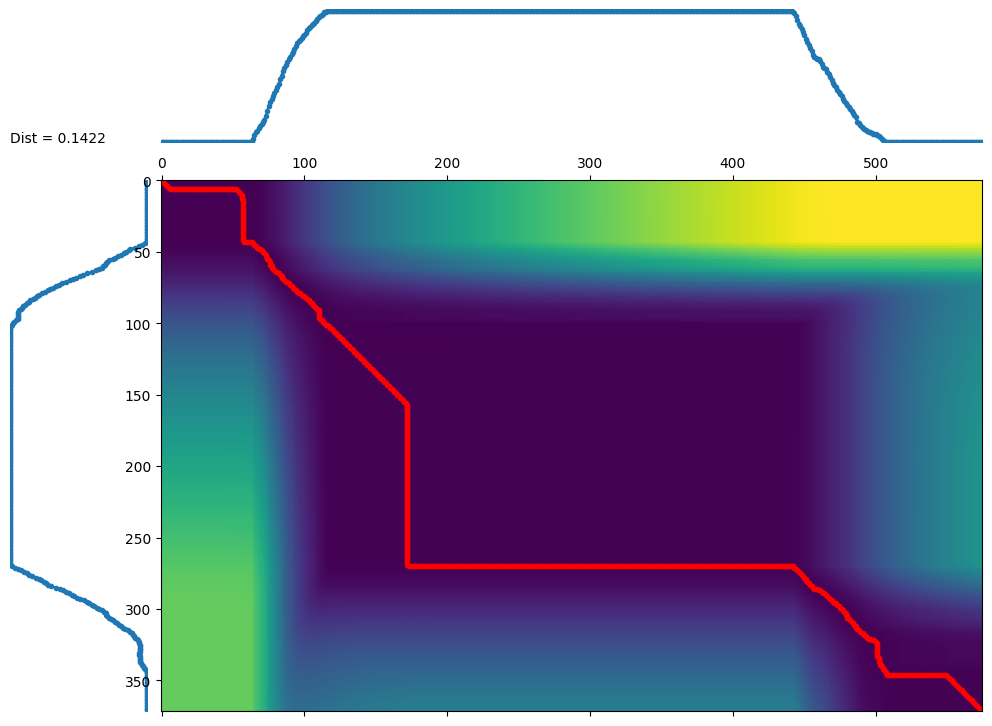

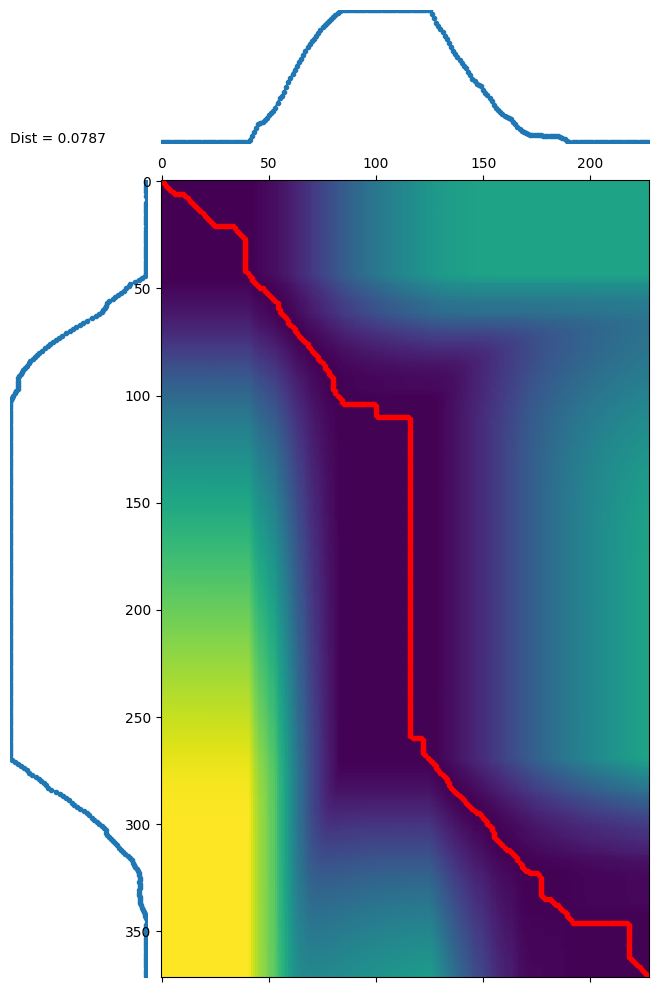

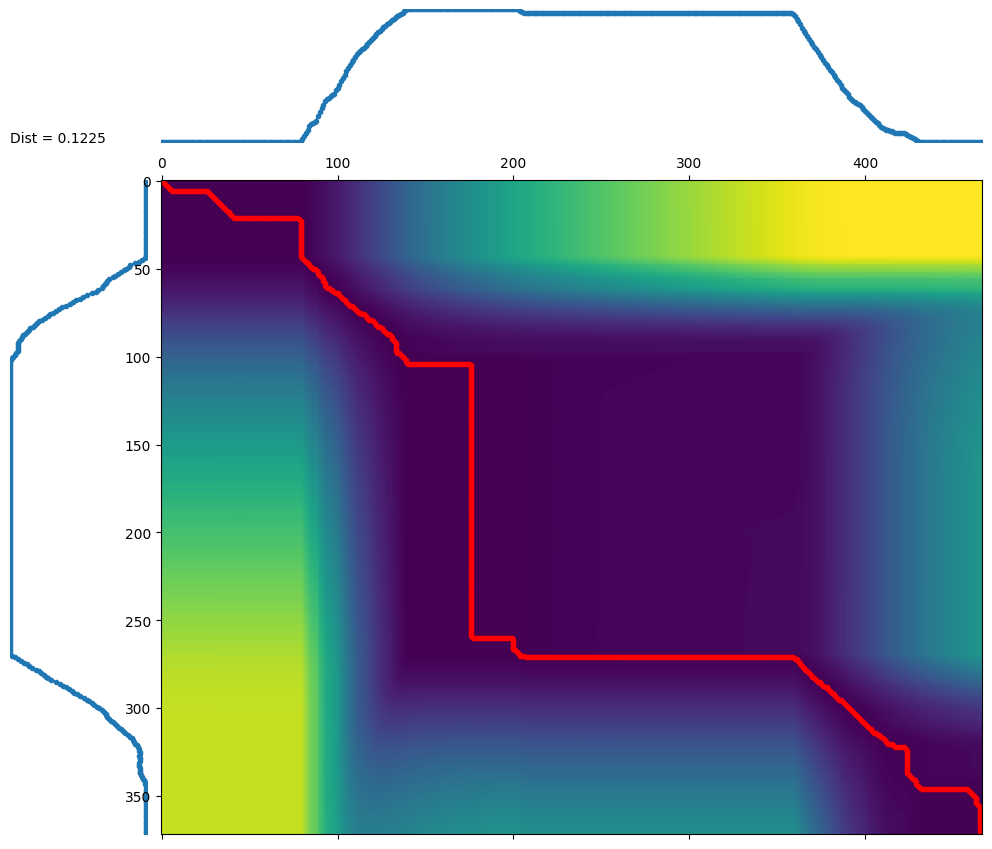

In [ ]:
reference = ds[11]
reference, ref_obs = preprocess_data(reference)
Errors = []

for i in range(len(ds)):
    print(f"Vol {i}")
    target = ds[i]
    target, tgt_obs = preprocess_data(target)

    # --------------------HMM-----------------------# 
    states = ["0", "1", "2", "3", "4"]
    n_states = len(states)
    model = create_hmm_model(n_states)
    model.fit(ref_obs)
    reference_HMM = detect_phases(reference, model, states)
    target_HMM = detect_phases(target, model, states)
    aligned_data_HMM = align_by_phase(reference_HMM, target_HMM, states)
    
    sync_error_with_phase = calculate_sync_error(reference, aligned_data_HMM, value_col="ALT[m]", metric="RMSE")
    reconstructed_flight_HMM = reconstruct_target(aligned_data_HMM, target)
    reconstruction_error_HMM = reconstruction_error(target, reconstructed_flight_HMM, col="ALT[m]")

    # --------------------Simple--------------------#
    aligned_data_no_phase = align_without_phases(reference, target)
    
    sync_error_no_phase = calculate_sync_error(reference, aligned_data_no_phase, value_col="ALT[m]", metric="RMSE")
    reconstructed_flight_no_phase = reconstruct_target(aligned_data_no_phase, target)
    reconstruction_error_no_phase = reconstruction_error(target, reconstructed_flight_no_phase, col="ALT[m]")

    # --------------------DTW-----------------------#
    distance, path = calculate_dtw(reference, target, col="ALT[m]")
    aligned_target_DTW = align_with_dtw(reference, target, path)

    sync_error_DTW = calculate_sync_error(reference, aligned_target_DTW, value_col="ALT[m]", metric="RMSE")
    reconstructed_flight_DTW = reconstruct_target(aligned_target_DTW, target)
    reconstruction_error_DTW = reconstruction_error(target, reconstructed_flight_DTW, col="ALT[m]")

    # Stocker toutes les erreurs
    Errors.append({
        "Erreur HMM (RMSE)": sync_error_with_phase,
        "Erreur Reconstruction HMM (RMSE)": reconstruction_error_HMM["RMSE"],
        "Erreur totale (somme des erreurs) HMM " : sync_error_with_phase + reconstruction_error_HMM["RMSE"],
        "Erreur sans phase (RMSE)": sync_error_no_phase,
        "Erreur Reconstruction sans phase (RMSE)": reconstruction_error_no_phase["RMSE"],
        "Erreur totale (somme des erreurs) sans phase " :  sync_error_no_phase +reconstruction_error_no_phase["RMSE"],
        "Erreur DTW (RMSE)": sync_error_DTW,
        "Erreur Reconstruction DTW (RMSE)": reconstruction_error_DTW["RMSE"],
        "Erreur totale (somme des erreurs) DTW " : sync_error_DTW+ reconstruction_error_DTW["RMSE"]
    })


In [ ]:
df_errors = pd.DataFrame(Errors)

print(df_errors["Erreur totale (somme des erreurs) HMM "].mean())

print(df_errors["Erreur totale (somme des erreurs) sans phase "].mean())
print(df_errors["Erreur totale (somme des erreurs) DTW "].mean())
df_errors

0.19203216175678914
0.1493407731369417
0.15274212412290963


Erreur HMM (RMSE)  Erreur Reconstruction HMM (RMSE)  \
0            0.022368                          0.043726   
1            0.062769                          0.107462   
2            0.037308                          0.074701   
3            0.031878                          0.183479   
4            0.067470                          0.382532   
5            0.045251                          0.304378   
6            0.023253                          0.096836   
7            0.021052                          0.188309   
8            0.021805                          0.117480   
9            0.090315                          0.084526   
10           0.241464                          0.272850   
11           0.000000                          0.000000   
12           0.057944                          0.237569   
13           0.024514                          0.063549   
14           0.054315                          0.023863   
15           0.018418                          0.194476   
16           0.021129                          0.178653   
17           0.024321                          0.109896   
18           0.028656                          0.180666   
19           0.078754                          0.033687   
20           0.047040                          0.096280   
21           0.017451                          0.072304   
22           0.052367                          0.033165   
23           0.038977                          0.344382   
24           0.021598                          0.132009   
25           0.040522                          0.407894   
26           0.040176                          0.288170   
27           0.018304                          0.245240   
28           0.053805                          0.162902   
29           0.021826                          0.017451   
30           0.072187                          0.069446   
31           0.108517                          0.094509   
32           0.092816                          0.256038   
33           0.022349                          0.101098   
34           0.016154                          0.074544   
35           0.036123                          0.127546   
36           0.023536                          0.133344   
37           0.057267                          0.143390   
38           0.078680                          0.107339   
39           0.051731                          0.119763   
40           0.020577                          0.024289   
41           0.047464                          0.101441   
42           0.023084                          0.152303   
43           0.026940                          0.142250   
44           0.036468                          0.138343   
45           0.036757                          0.331598   
46           0.020576                          0.133558   

    Erreur totale (somme des erreurs) HMM   Erreur sans phase (RMSE)  \
0                                 0.066094                  0.038350   
1                                 0.170231                  0.077156   
2                                 0.112009                  0.086963   
3                                 0.215357                  0.181189   
4                                 0.450002                  0.406475   
5                                 0.349629                  0.300058   
6                                 0.120089                  0.091260   
7                                 0.209361                  0.192297   
8                                 0.139285                  0.124228   
9                                 0.174840                  0.160374   
10                                0.514314                  0.110170   
11                                0.000000                  0.000000   
12                                0.295513                  0.227126   
13                                0.088064                  0.057915   
14                                0.078178                  0.057311   
15                 

# Reconstruction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

def interpolate_curve(points, aligned_target, target_length, col="ALT[m]"):
    """ Interpole la courbe à partir des points donnés. """
    x = np.array(points)
    y = aligned_target[col].values[x]

    # Interpolation linéaire (on pourra tester des splines ensuite)
    interp_func = interp1d(x, y, kind="linear", fill_value="extrapolate")
    return interp_func(np.linspace(0, target_length - 1, target_length))

def compute_error(positions, aligned_target, target, col="ALT[m]"):
    """ Fonction objectif : erreur entre la courbe interpolée et la cible """
    positions = np.sort(positions.astype(int))  # On force des positions valides
    reconstructed = interpolate_curve(positions, aligned_target, len(target), col)
    return mean_squared_error(target[col], reconstructed)

def optimize_points(aligned_target, target, col="ALT[m]", n_points=10):
    """ Trouve la meilleure position des points pour minimiser l'erreur """
    initial_positions = np.linspace(0, len(aligned_target) - 1, n_points, dtype=int)
    
    bounds = [(0, len(aligned_target) - 1) for _ in range(n_points)]

    result = minimize(compute_error, initial_positions, args=(aligned_target, target, col), bounds=bounds)

    best_positions = np.sort(result.x.astype(int))
    reconstructed_target = interpolate_curve(best_positions, aligned_target, len(target), col)
    return best_positions, reconstructed_target, result.fun  # Meilleure erreur obtenue

def plot_optimization(target, aligned_target, reconstructed, points, col="ALT[m]"):
    """ Affiche le résultat de l'optimisation """
    plt.figure(figsize=(8, 5))
    plt.plot(target[col].values, label="Target", color="blue", linewidth=1)
    plt.plot(reconstructed, label="Interpolated", color="red", linestyle="dashed")
    plt.scatter(points, aligned_target[col].values[points], color="black", label="Selected Points")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.title("Optimisation de l'interpolation")
    plt.legend()
    plt.grid()
    plt.show()

# Exécution
col = "ALT[m]"
n_points = 10

best_points, reconstructed_target, best_error = optimize_points(aligned_target_DTW, target, col, n_points)
plot_optimization(target, aligned_target_DTW, reconstructed_target, best_points, col)

print(f"Meilleure erreur obtenue : {best_error:.4f}")


c:\Users\ruber\OneDrive\Bureau\MDD\venv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning:

invalid value encountered in divide



ValueError: Input contains NaN.